# FINAL PROJECT - WEATHER FORECASTING

GIADA PALMA VR471280

<b>Brief description of the dataset</b><br>
This dataset provides training data on weather from 1st January 2013 to 31st December 2016. An additional testing set is available, enclosing the period 1st January 2017 to 31st March 2017, which corresponds to the forecast interval. <br>
There are 4 parameters describing weather, that are <i>meantemp, humidity, wind_speed, meanpressure.</i><br><br>
<b>Objective</b><br>
The main aim of this project is to perform weather forecasting for the period January-March 2017.

## 0. Importing needed libraries

In [1]:
import math
import statistics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

import numpy as np
import pandas as pd
from pandas.plotting import lag_plot

from scipy import stats, signal
from datetime import datetime

import sklearn 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.nonparametric.smoothers_lowess import lowess

import warnings
warnings.filterwarnings("ignore")

## 1. Loading and converting the data 

I want to read the data from the csv file.

In [2]:
dataset = pd.read_csv('Weather ForecastingTrain.csv', sep=',')

In [3]:
dataset_test = pd.read_csv('Weather ForecastingTest.csv', sep=',')

I set parameters for the graphical visualisations

In [202]:
plt.rcParams["figure.figsize"] = (26, 6)
plt.rcParams["figure.titlesize"] = 18
plt.rcParams["figure.titleweight"] = 'bold'
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.loc"] = 'upper left'

I want to have a first overview of the data contained in the dataset.

In [203]:
# Show the first and last 5 rows
display(dataset.head())
display(dataset.tail())

# Show data type of the columns
ds_types = dataset.dtypes
print('\nVisualise columns types:\n', ds_types)

# Show how many rows and columns are present in the dataframe
rows, columns = dataset.shape
print(f'\nThe ds is composed by: {rows} rows and {columns} columns.')

date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

date   meantemp   humidity  wind_speed  meanpressure
1456  2016-12-27  16.850000  67.550000    8.335000   1017.200000
1457  2016-12-28  17.217391  68.043478    3.547826   1015.565217
1458  2016-12-29  15.238095  87.857143    6.000000   1016.904762
1459  2016-12-30  14.095238  89.666667    6.266667   1017.904762
1460  2016-12-31  15.052632  87.000000    7.325000   1016.100000


Visualise columns types:
 date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

The ds is composed by: 1461 rows and 5 columns.


It is visible that the date column is of type object. In order to best exploit information recorded in this column, I am going to convert this into a type date column and assign that as an index.

In [204]:
# Transform date column from object to date time
dataset['date'] = pd.to_datetime(dataset['date'])

# Check data type of date column
display(dataset['date'].dtypes)

# Set date column as index
dataset = dataset.set_index('date')
display(dataset.index)

dtype('<M8[ns]')

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=1461, freq=None)

In [205]:
# Transform date column from object to date time also for the testing dataset
dataset_test['date'] = pd.to_datetime(dataset_test['date'])

# Set date column as index
dataset_test = dataset_test.set_index('date')
display(dataset_test.index)

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
      

Setting the frequency as daily.

In [206]:
dataset.index.freq='D'
dataset_test.index.freq='D'

In [207]:
dataset.describe()

meantemp     humidity   wind_speed  meanpressure
count  1461.000000  1461.000000  1461.000000   1461.000000
mean     25.506127    60.744851     6.806865   1011.101197
std       7.339416    16.743928     4.559688    180.293335
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.571429
50%      27.714286    62.625000     6.250000   1008.555556
75%      31.312500    72.125000     9.250000   1014.937500
max      38.714286    98.000000    42.220000   7679.333333

In [208]:
dataset_test.describe()

meantemp   humidity  wind_speed  meanpressure
count  90.000000  90.000000   90.000000     90.000000
mean   19.302256  63.151742    7.881385   1003.893825
std     4.687991  14.872217    3.311143    100.807387
min    11.000000  34.500000    1.625000     59.000000
25%    15.753261  50.738095    5.561667   1010.643750
50%    18.579167  66.772727    7.756250   1015.375000
75%    21.484091  75.093254   10.039583   1017.601103
max    31.000000  95.833333   17.590000   1022.809524

In [209]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2013-01-01 to 2016-12-31
Freq: D
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1461 non-null   float64
 1   humidity      1461 non-null   float64
 2   wind_speed    1461 non-null   float64
 3   meanpressure  1461 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [210]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2017-01-01 to 2017-03-31
Freq: D
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      90 non-null     float64
 1   humidity      90 non-null     float64
 2   wind_speed    90 non-null     float64
 3   meanpressure  90 non-null     float64
dtypes: float64(4)
memory usage: 3.5 KB


I want to check if there are any either null or NaN values in the training dataset.

In [211]:
null_elem = dataset.isnull().sum()
print('Total number of null is:\n', null_elem)

null_elem = dataset.isna().sum()
print('\nTotal number of NaN is:\n', null_elem)

Total number of null is:
 meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Total number of NaN is:
 meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


## 2. Visualising the data

I want to visualise the data graphically.

In [212]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.03)

fig.add_trace(go.Scatter(y=dataset['meantemp'], x=dataset.index,  name="meantemp"), row=1, col=1)
fig.add_trace(go.Scatter(y=dataset['humidity'], x=dataset.index, name="humidity"), row=2, col=1)
fig.add_trace(go.Scatter(y=dataset['wind_speed'], x=dataset.index, name="wind_speed"), row=3, col=1)
fig.add_trace(go.Scatter(y=dataset['meanpressure'], x=dataset.index, name="meanpressure"), row=4, col=1)

fig.update_layout(height=1000, width=1600, title_text="Features visualisation")
fig.show()

In [213]:
fig = make_subplots(rows=1, cols=4, horizontal_spacing=0.03)

fig.add_trace(go.Box(y=dataset['meantemp'], x=dataset.index.year, name="meantemp"), row=1, col=1)
fig.add_trace(go.Box(y=dataset['humidity'], x=dataset.index.year, name="humidity"), row=1, col=2)
fig.add_trace(go.Box(y=dataset['wind_speed'], x=dataset.index.year, name="wind_speed"), row=1, col=3)
fig.add_trace(go.Box(y=dataset['meanpressure'], x=dataset.index.year, name="meanpressure"), row=1, col=4)

fig.update_layout(height=800, width=1600, title_text="Box plot for fetures visualisation")
fig.show()

## 3. Exploring the data

* <b>CORRELATION</b> analysis between columns of the dataset.

Firstly, I check for the <b>Spearman rank correlation</b>, which uses nonparametric measures of rank correlation.<br>
Secondly, I use the <b>Pearson</b> correlation, which assesses linear relationships.

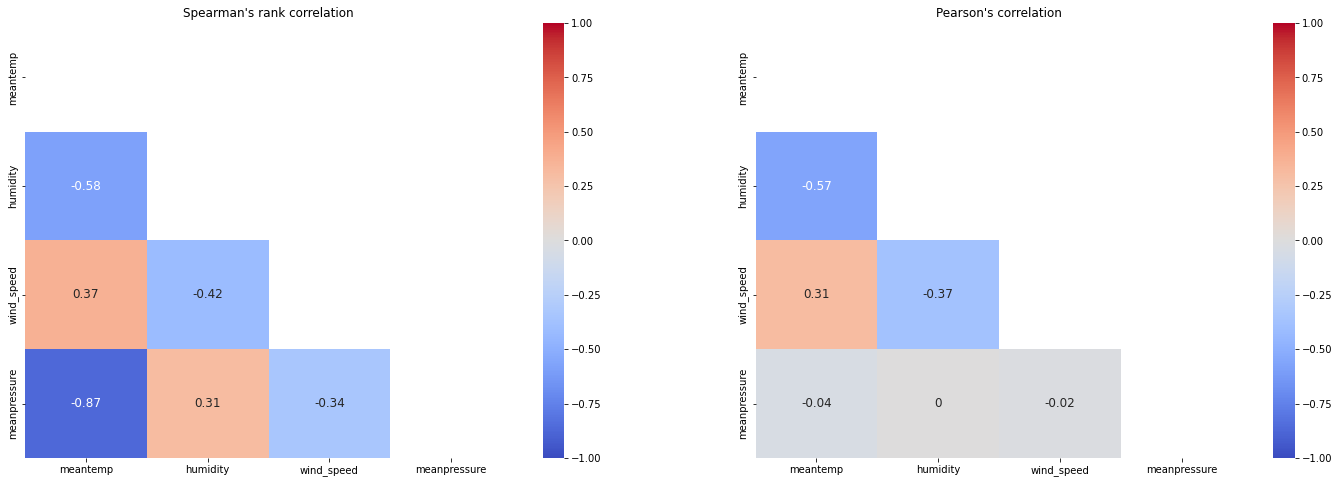

In [214]:
spearman_corr = dataset.corr(method = 'spearman', min_periods=1).round(2)
mask_spe = np.triu(np.ones_like(spearman_corr, dtype=bool))

pearson_corr = dataset.corr(method = 'pearson', min_periods=1).round(2)
mask_pea = np.triu(np.ones_like(pearson_corr, dtype=bool))


fig, ax = plt.subplots(1, 2, figsize=(24, 8))
sns.heatmap(spearman_corr, annot=True, ax=ax[0], annot_kws={"size":12}, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask_spe)
ax[0].set_title('Spearman\'s rank correlation')
sns.heatmap(pearson_corr, annot=True, ax=ax[1], annot_kws={"size":12}, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask_pea)
ax[1].set_title('Pearson\'s correlation')
plt.show()

From the graphs it is clear that<br>
* SPEARMAN'S RANK CORRELATION:<br>
On one hand the mean temperature and the speed of the wind, as well as the mean pressure and the humidity are weak positive rank associated with a ρ value of 0.3. <br>
On the other hand, the mean pressure and the mean temperature are strong negative correlated with a ρ value of -0.8.
<br>
* PEARSON'S CORRELATION: <br>
From the matrix we can see that the mean temperature and the wind speed have a moderate linear relationship with a coefficient value r of 0.3. <br>

It is interesting to notice that, with the Spearman's rank correlation it can be captured also the monotonic relationship between the mean pressure and the humidity, which would have not been considered if just the Pearson's correlation was taken into consideration.

In [215]:
fig = make_subplots(cols=3, rows=2, vertical_spacing=0.03, horizontal_spacing=0.05)

fig.add_trace(go.Scatter(y=dataset['humidity'], x=dataset['meantemp'], mode='markers', name="humidity"), row=1, col=1, )
fig.add_trace(go.Scatter(y=dataset['wind_speed'], x=dataset['meantemp'], mode='markers', name="wind_speed"), row=1, col=2)
fig.add_trace(go.Scatter(y=dataset['meanpressure'], x=dataset['meantemp'], mode='markers', name="meanpressure"), row=1, col=3)

fig.add_trace(go.Scatter(y=dataset['humidity'], x=dataset['meanpressure'], mode='markers', name="humidity"), row=2, col=1)
fig.add_trace(go.Scatter(y=dataset['wind_speed'], x=dataset['meanpressure'], mode='markers', name="wind_speed"), row=2, col=2)
fig.add_trace(go.Scatter(y=dataset['meantemp'], x=dataset['meanpressure'], mode='markers', name="meanpressure"), row=2, col=3)

fig.update_layout(height=800, width=1600, title_text="Scatterplot visualisation of the relationship between features")
fig.show()

* <b>RANDOMNESS</b> analysis.

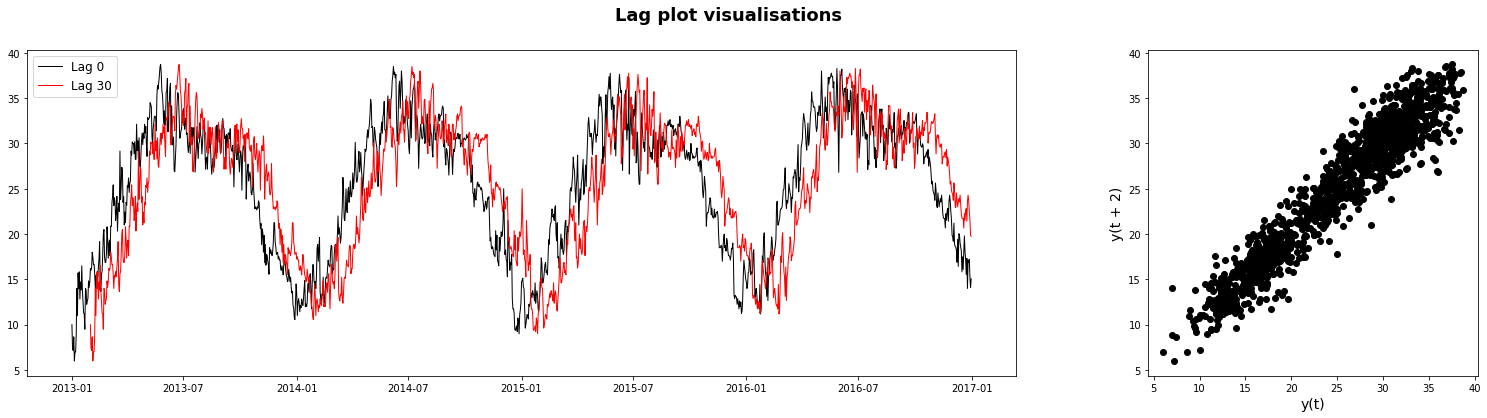

In [216]:
temperature = [ {'name': 'Lag 0', 'y': dataset['meantemp'],'color':'k', 'linewidth':1},
                {'name': 'Lag 30', 'y':  dataset['meantemp'].shift(30),'color':'r', 'linewidth':1}]

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
for line_lag in temperature:
    ax[0].plot(line_lag['y'], color=line_lag['color'], linewidth=line_lag['linewidth'], label=line_lag['name'])
ax[0].legend()
fig.suptitle('Lag plot visualisations')
pd.plotting.lag_plot(dataset['meantemp'], lag=2, c='k')   
plt.show()


In the first graph on the left, I have plotted the 30th lag of the variable meantemp. Clearly a non-random structure is visible.<br>
Additionally, in the scatterplot on the right handside the data has been lagged using lag = 2 and there are neither big outliers, nor randomness because the data shows somehow a linear pattern suggesting there is positive autocorrelation.

* <b>STATIONARITY</b> analysis.

I will firstly perform a naive check by looking at the distribution.

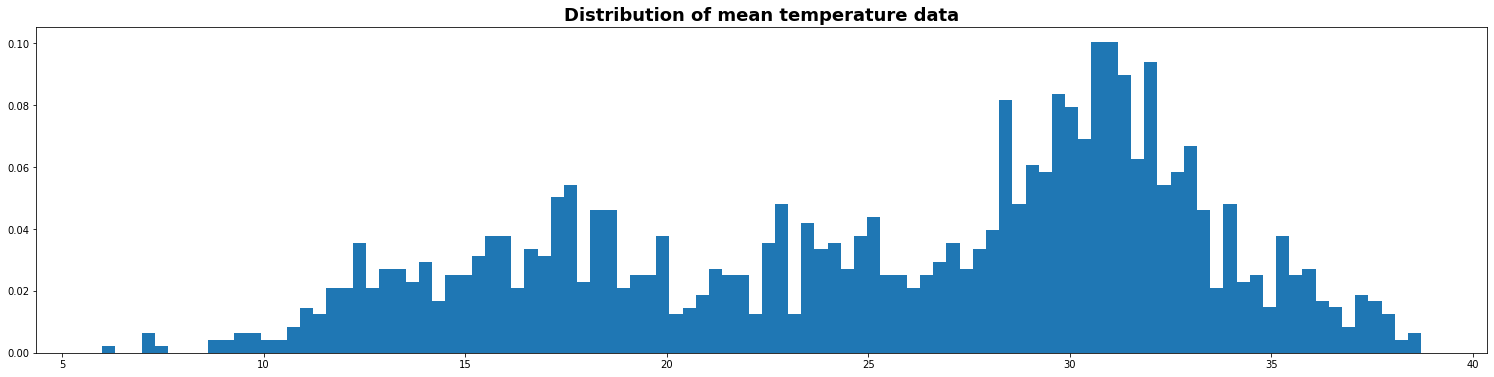

In [217]:
plt.hist(dataset['meantemp'], bins=100, density=True)
plt.title("Distribution of mean temperature data", fontsize=18, fontweight='bold')
plt.show()

The histogram does not show a perfect Gaussian distribution.<br>
I will try, now, to split the time series into 2 parts and see if there are substancial differences in the mean and the variance.

In [222]:
mean_temp = dataset['meantemp'].values
split = int(len(mean_temp) / 2)
mean_temp1, mean_temp2 = mean_temp[0:split], mean_temp[split:]

mean_tempJan_Mar, mean_tempJul_Sept = mean_temp[0:90], mean_temp[210:300]

mean1, mean2, meanJan_Mar, meanJul_Sept = mean_temp1.mean(), mean_temp2.mean(), mean_tempJan_Mar.mean(), mean_tempJul_Sept.mean()
var1, var2, varJan_Mar, varJul_Sept = mean_temp1.var(), mean_temp2.var(), mean_tempJan_Mar.var(), mean_tempJul_Sept.var()

print('Mean of the first half = %f, mean of the second half = %f' % (mean1, mean2))
print('Variance of the first half = %f, variance of the second half = %f' % (var1, var2))
print()
print('Mean of period January-March = %f, mean of period July-September = %f' % (meanJan_Mar, meanJul_Sept))
print('Variance of period January-March = %f, variance of period July-September = %f' % (varJan_Mar, varJul_Sept))

Mean of the first half = 24.901083, mean of the second half = 26.110343
Variance of the first half = 56.165570, variance of the second half = 50.767279

Mean of period January-March = 17.265000, mean of period July-September = 28.759405
Variance of period January-March = 26.394129, variance of period July-September = 5.560953


Apparently if I split the dataset into two parts, there is no significant difference in mean and variance of the two splits, but clearly it depends on the fact that Winter and Spring have similar temperatures to Summer and Autumn on average and variance, but I if I take into consideration smaller splits of the dataset, like 3 months in winter and 3 in the summer obviously I am expecting the series to be non stationary, having mean and variance very different.

* <b>ADF</b> test

To be 100% sure that the series is not stationary as I suspect, I need to perform the <b> ADF Augmented Dickey-Fuller</b> statistical test, to define how strongly the series is defined by a trend. 

The null hypothesis H0 of the ADF test is that the time series in non stationary, contrarely the alternate hypothesis H1 is that the null hypothesis is rejected, hence the time series is stationary. <br>
To interpret the result I have to look at the <b>p-value</b>: 
- if the p-value is below the threshold (5%) it suggests that the H0 has to be rejected (so the series is stationary), 
- otherwise we fail to reject H0 and the series is non-stationary. <br>

I also have some critical values that suggest the significance level by which I can reject the H0. <br>
My p-value is greater than 0.05, therefore I fail to reject H0 and the series is non-stationary as suspected.

In [241]:
def adf_test(series, param):
    result_ADF = adfuller(series, autolag=param)
    print('ADF Statistic:', result_ADF[0])
    print('ADF p-value:', result_ADF[1])
    print('Critical Values:')
    for key, value in result_ADF[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'Result: The series is {"not " if result_ADF[1] >= 0.05 else ""}stationary')

In [243]:
adf_test(dataset['meantemp'].values, 'AIC')

ADF Statistic: -2.155565227446429
ADF p-value: 0.22276593986733573
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Result: The series is not stationary


Another test that I need to use is the <b> KPSS (Kwiatkowski-Phillips-Schmidt-Shin) </b> test for stationarity around a given trend. <br>
It must be kept in mind that in the KPSS the null hypothesis tests for stationarity, the opposite of the ADF test.

In [244]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [245]:
kpss_test(dataset['meantemp'].values)

KPSS Statistic: 0.19176382197969408
p-value: 0.1
num lags: 25
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


On the other hand the KPSS test tells me that the series is trend stationary.<br>
But let's do some other checks to understand wich AR or MA parameters should I select for the ARIMA model I want to use to forecast data.

- LOG TRANSFORM

I try to apply the logarithm to see if something changes with a log transform.

In [237]:
log_transform = np.log(mean_temp)
dataset['meantemp_log'] = log_transform

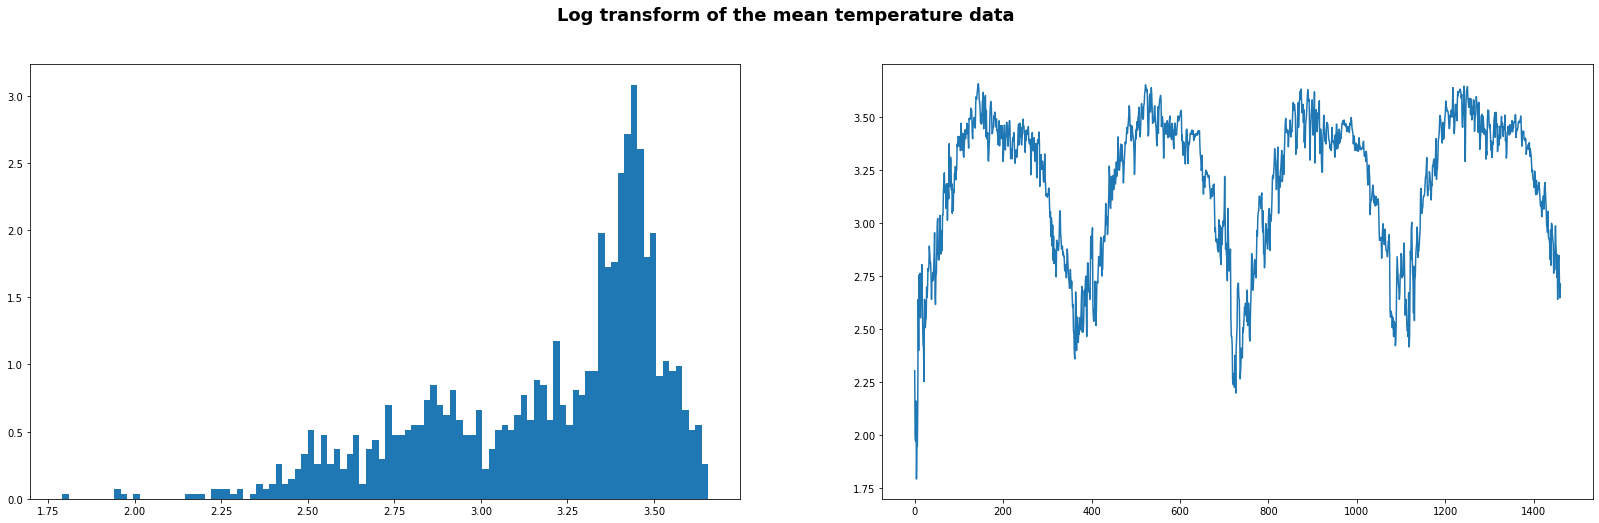

Mean of the first half = 3.159581, mean of the second half = 3.217706
Variance of the first half = 0.123985, variance of the second half = 0.098511

Mean of period January-March = 2.797630, mean of period July-September = 3.355445
Variance of period January-March = 0.112274, variance of period July-September = 0.007213


In [239]:
fig, ax = plt.subplots(1, 2, figsize=(28, 8))
ax[0].hist(log_transform, bins=100, density=True)
ax[1].plot(log_transform)
fig.suptitle("Log transform of the mean temperature data")
plt.show()

split = int(len(mean_temp) / 2)
log_transform1, log_transform2 = log_transform[0:split], log_transform[split:]
log_transfJan_Mar, log_transfJul_Sept = log_transform[0:90], log_transform[210:300]

mean1, mean2, meanJan_Mar, meanJul_Sept = log_transform1.mean(), log_transform2.mean(), log_transfJan_Mar.mean(), log_transfJul_Sept.mean()
var1, var2, varJan_Mar, varJul_Sept = log_transform1.var(), log_transform2.var(), log_transfJan_Mar.var(), log_transfJul_Sept.var()

print('Mean of the first half = %f, mean of the second half = %f' % (mean1, mean2))
print('Variance of the first half = %f, variance of the second half = %f' % (var1, var2))
print()
print('Mean of period January-March = %f, mean of period July-September = %f' % (meanJan_Mar, meanJul_Sept))
print('Variance of period January-March = %f, variance of period July-September = %f' % (varJan_Mar, varJul_Sept))

After having applied a log transform, the difference between the statistics appears smaller as expected.

Now I will try to perform the ADF test on a log transformed of the series.

In [246]:
adf_test(log_transform, 'AIC')

ADF Statistic: -3.8412307997289115
ADF p-value: 0.002512547505017688
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Result: The series is stationary


I apply the KPSS on the log transformed series as well.

In [247]:
kpss_test(log_transform)

KPSS Statistic: 0.20322614575738787
p-value: 0.1
num lags: 25
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


As a result, after applying the logarithmic transformation the series becomes stationary with both tests.

- DIFFERENCING

Another operation that I can do, is to transform the series by differencing, i.e computing the difference consecutive observations. Differencing can remove trend and seasonality, stabilising the mean of the series.

a. Seasonal differencing

In [249]:
#Seasonal differencing
dataset['meantemp_diff_365'] = dataset['meantemp'].diff(periods=365)
dataset.dropna(inplace=True)

In [250]:
adf_test(dataset['meantemp_diff_365'].values, 'AIC')

ADF Statistic: -10.084459784462178
ADF p-value: 1.1652774953985278e-17
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Result: The series is stationary


In [251]:
kpss_test(dataset['meantemp_diff_365'].values)

KPSS Statistic: 1.0309468949263478
p-value: 0.01
num lags: 16
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


In [252]:
#Twice seasonal differencing
dataset['meantemp_diff_365_double'] = dataset['meantemp_diff_365'].diff(periods=365)
dataset.dropna(inplace=True)

In [254]:
adf_test(dataset['meantemp_diff_365_double'], 'AIC')

ADF Statistic: -10.52325522102861
ADF p-value: 9.561205636141914e-19
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
Result: The series is stationary


In [255]:
kpss_test(dataset['meantemp_diff_365_double'].values)

KPSS Statistic: 0.43105206694446385
p-value: 0.06377066079980007
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


In [256]:
#Seasonal and then first order differencing
dataset['meantemp_diff_365_fo'] = dataset['meantemp_diff_365'].diff()
dataset.dropna(inplace=True)

In [257]:
result_ADF_meantemp_diff = adfuller(dataset['meantemp_diff_365_fo'], autolag='AIC')
print('ADF Statistic: %f' % result_ADF_meantemp_diff[0])
print('p-value: %f' % result_ADF_meantemp_diff[1])
print('Critical Values:')
for key, value in result_ADF_meantemp_diff[4].items():
    print('\t%s: %.3f' % (key, value))
print(f'Result: The series is {"not " if result_ADF_meantemp_diff[1] >= 0.05 else ""}stationary')

ADF Statistic: -9.932231
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Result: The series is stationary


In [258]:
kpss_test(dataset['meantemp_diff_365_fo'].values)

KPSS Statistic: 0.04297126213778348
p-value: 0.1
num lags: 56
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


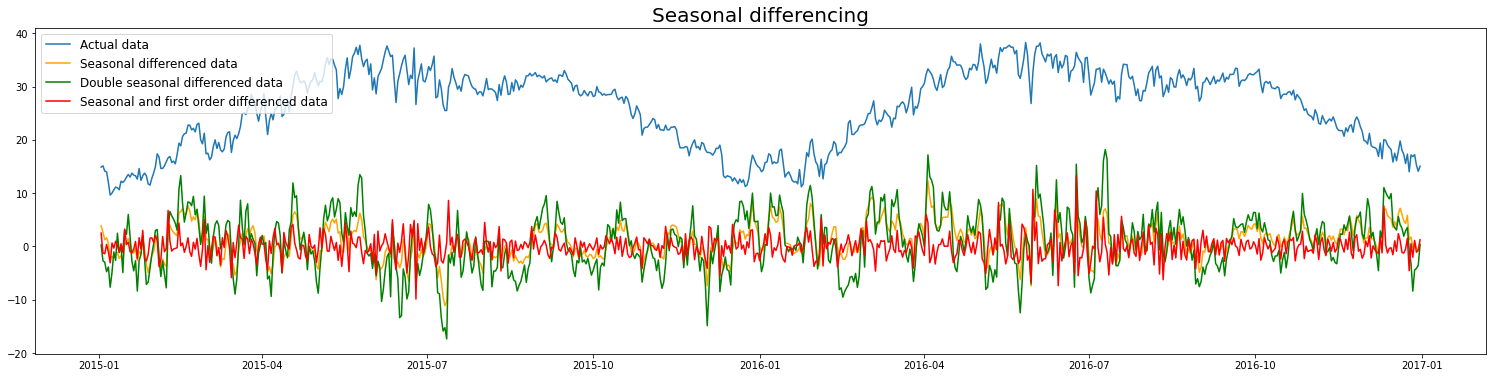

In [260]:
plt.title('Seasonal differencing', size=20)
plt.plot(dataset['meantemp'], label='Actual data')
plt.plot(dataset['meantemp_diff_365'], label='Seasonal differenced data', color='orange')
plt.plot(dataset['meantemp_diff_365_double'], label='Double seasonal differenced data', color='green')
plt.plot(dataset['meantemp_diff_365_fo'], label='Seasonal and first order differenced data', color='red')
plt.legend()
plt.show()

With this graph we can clearly see that by using a seasonal differencing we can flatten the curve and remove seasonality

b. First order differencing

In [261]:
#First order differencing
dataset['meantemp_diff'] = dataset['meantemp'].diff()
dataset.dropna(inplace=True)
dataset.head()

meantemp  humidity  wind_speed  meanpressure  meantemp_log  \
date                                                                     
2015-01-03    15.125    92.000      0.9250      1017.375      2.716349   
2015-01-04    14.125    78.750      9.5125      1019.625      2.647946   
2015-01-05    14.000    69.375     15.0500      1016.000      2.639057   
2015-01-06    12.000    79.875      4.4000      1015.500      2.484907   
2015-01-07     9.625    86.000      3.9375      1016.625      2.264364   

            meantemp_diff_365  meantemp_diff_365_double  meantemp_diff_365_fo  \
date                                                                            
2015-01-03           2.625000                 -2.708333             -1.250000   
2015-01-04           1.250000                 -2.958333             -1.375000   
2015-01-05           1.625000                 -4.750000              0.375000   
2015-01-06           0.571429                 -3.857143             -1.053571   
2015-01-07          -2.517857                 -7.660714             -3.089286   

            meantemp_diff  
date                       
2015-01-03          0.250  
2015-01-04         -1.000  
2015-01-05         -0.125  
2015-01-06         -2.000  
2015-01-07         -2.375

In [262]:
adf_test(dataset['meantemp_diff'].values, 'AIC')

ADF Statistic: -12.09685501657612
ADF p-value: 2.0610754376420536e-22
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
Result: The series is stationary


In [263]:
kpss_test(dataset['meantemp_diff'].values)

KPSS Statistic: 0.25333941869049514
p-value: 0.1
num lags: 44
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


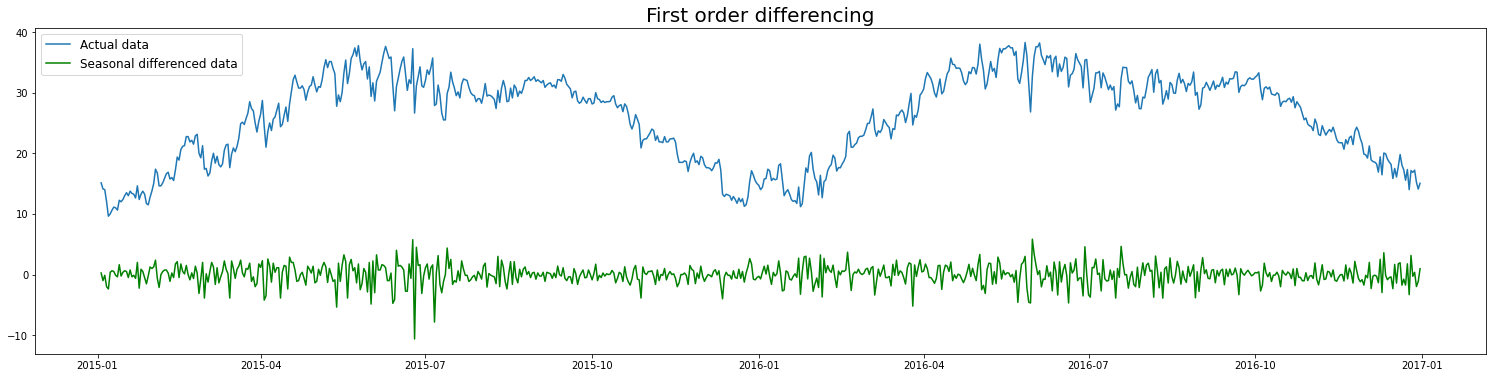

In [42]:
plt.title('First order differencing', size=20)
plt.plot(dataset['meantemp'], label='Actual data')
plt.plot(dataset['meantemp_diff'], label='Seasonal differenced data', color='green')
plt.legend()
plt.show()

With first order differencing the data is flattened and it's clearly stationary as the tests suggest.

* Lastly I want to check for <b>AUTOCORRELATION</b>

I want to measure the linear relationship between lagged values of the time series.<br> 
Therefore, I will plot both the <i>autocorrelation function (ACF) </i> and the <i> partial autocorrelation function (ACF)</i> on the differenced data.

With the ACF function it is possible to understand if there is correlation of observations with values at previous times. <br>
With the PACF function it is possible to understand relationship between an observation and another at previous times, without the effect of intermediate values, so we get a direct effect.

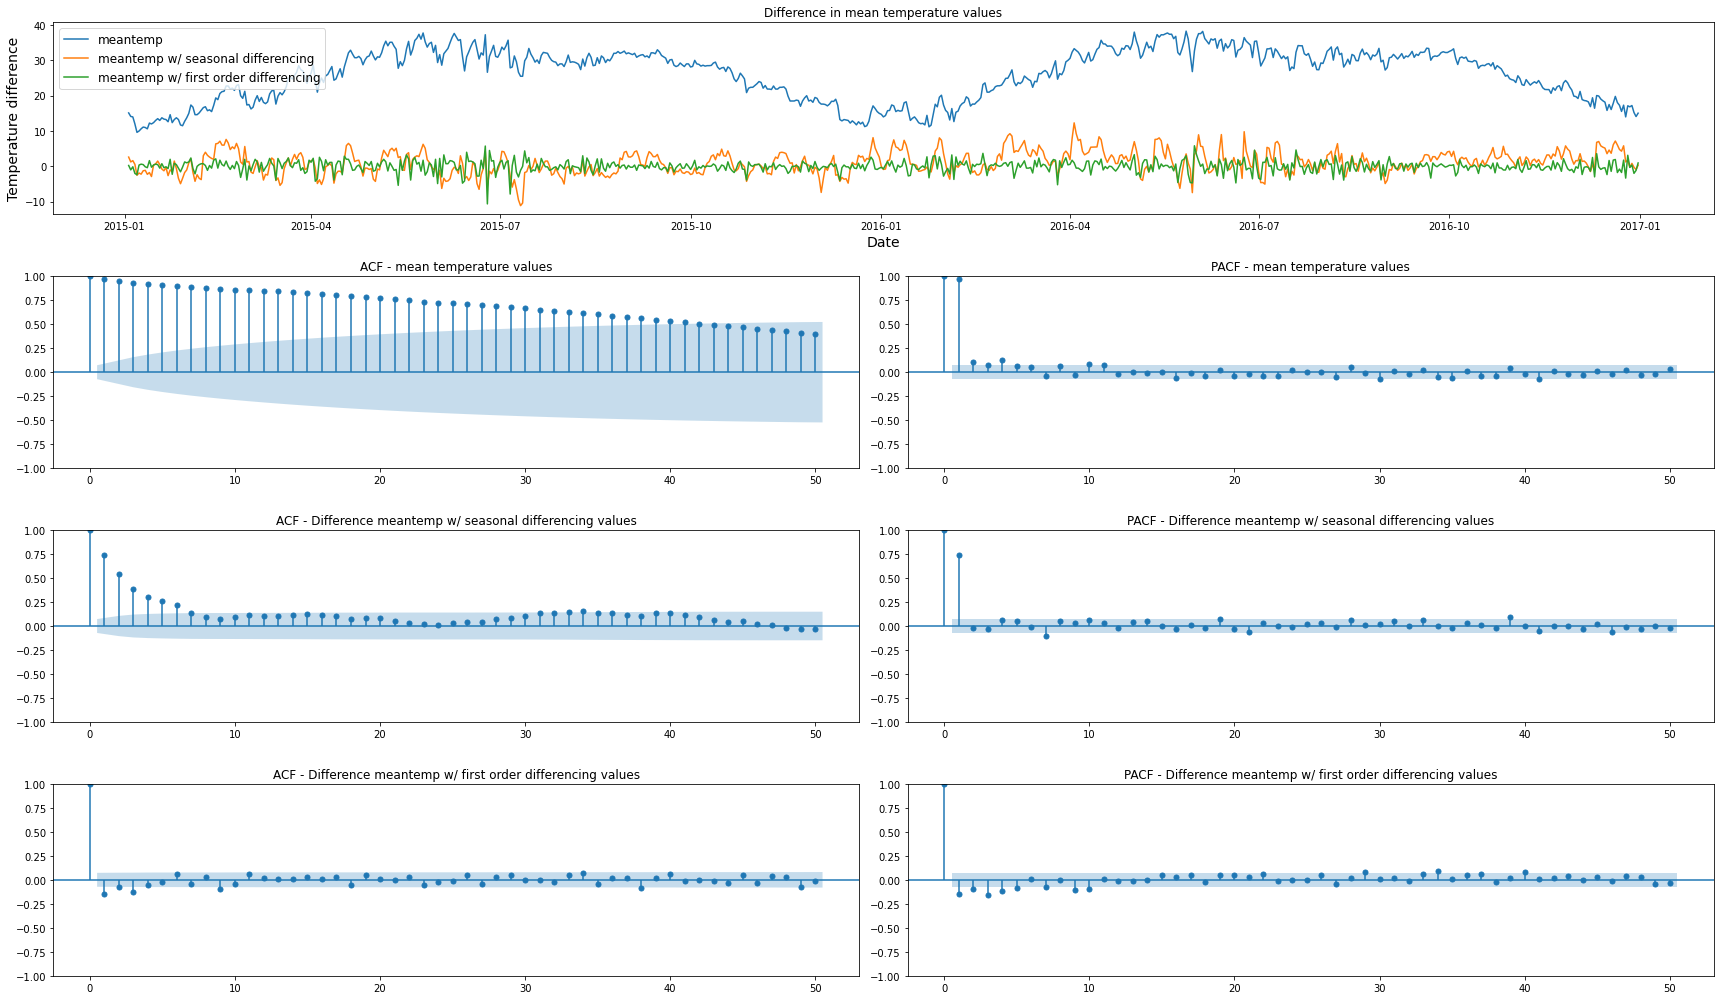

In [267]:
fig = plt.figure(figsize=(24,14)) 
ax1 = plt.subplot2grid(shape=(4, 2), loc=(0, 0), colspan=3)
ax2 = plt.subplot2grid(shape=(4, 2), loc=(1, 0), colspan=1)
ax3 = plt.subplot2grid(shape=(4, 2), loc=(1, 1), colspan=1)
ax4 = plt.subplot2grid(shape=(4, 2), loc=(2, 0), colspan=1)
ax5 = plt.subplot2grid(shape=(4, 2), loc=(2, 1), colspan=1)
ax6 = plt.subplot2grid(shape=(4, 2), loc=(3, 0), colspan=1)
ax7 = plt.subplot2grid(shape=(4, 2), loc=(3, 1), colspan=1)

ax1.plot(dataset.index, dataset['meantemp'], label='meantemp')
ax1.plot(dataset.index, dataset['meantemp_diff_365'], label='meantemp w/ seasonal differencing')
ax1.plot(dataset.index, dataset['meantemp_diff_365_fo	'], label='meantemp w/ first order differencing')

ax1.legend(loc='best')
ax1.set_title('Difference in mean temperature values')
ax1.set_ylabel('Temperature difference')
ax1.set_xlabel('Date')

plot_acf(dataset['meantemp'], lags=50, title='ACF - mean temperature values',ax=ax2)
plot_acf(dataset['meantemp_diff_365'], lags=50, title='ACF - Difference meantemp w/ seasonal differencing values', ax=ax4)
plot_acf(dataset['meantemp_diff_365_fo	'], lags=50, title='ACF - Difference meantemp w/ first order differencing values', ax=ax6)

plot_pacf(dataset['meantemp'], lags=50, title='PACF - mean temperature values',ax=ax3, method='ywmle')
plot_pacf(dataset['meantemp_diff_365'], lags=50, title='PACF - Difference meantemp w/ seasonal differencing values', ax=ax5, method='ywmle')
plot_pacf(dataset['meantemp_diff_365_fo	'], lags=50, title='PACF - Difference meantemp w/ first order differencing values', ax=ax7, method='ywmle')


plt.tight_layout()
plt.show()

The Autocorrelation function after seasonal differencing has 6 significant lags and then decreases. <br>
The Partial Autocorrelation after seasonal differencing is significant at the first lag and the seventh lag and the remaining lags abruptly fall to zero.<br>
--- -
The Autocorrelation function after first order differencing has 3 significant lags. <br>
The Partial Autocorrelation after first order differencing has 5 significant lags.<br>
--- -
These observations, hence, suggest to use an AR process with parameter p more or less equal 2, a MA process with parameter q more or less equal to 3.

* FREQUENCY ANALYSIS

Freq  Period         Power
0  0.002743  364.50  28766.924994
1  0.005487  182.25   4322.184968

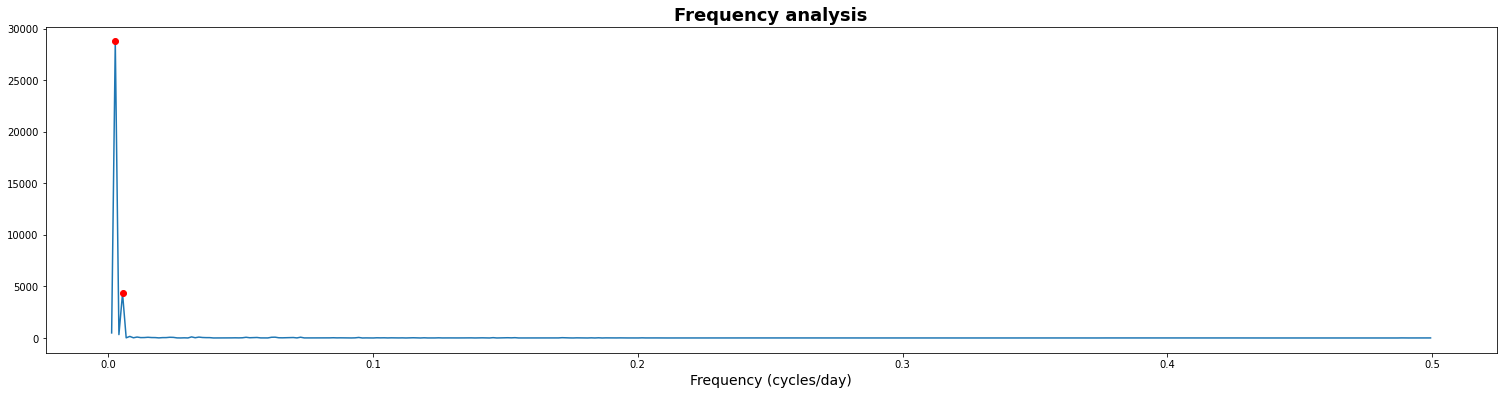

In [268]:
# Derive PSD using the periodogram and identify the periodicities in the data
signal_time = dataset['meantemp']
Fs = 1 #1 per day
f_per, Pxx_per = signal.periodogram(signal_time, Fs, detrend=None, window=None, return_onesided=True, scaling='density')
plt.plot(f_per[1:], Pxx_per[1:])
plt.xlabel('Frequency (cycles/day)')

peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=500)[0]
peak_freq =  f_per[peaks]
period_peak = 1/peak_freq
peak_power = Pxx_per[peaks]
plt.plot(peak_freq, peak_power, 'ro')
plt.title("Frequency analysis", fontsize=18, fontweight='bold')

data = {'Freq': peak_freq, 'Period': period_peak, 'Power': peak_power}
df = pd.DataFrame(data)
display(df)

By the frequency analysis it is clear that the data has a frequency of 365 days, i.e. annual.

In [269]:
#############################
# CHECK INDEX FREQUENCY
############################
print(dataset.index)
print("Inferred: ", dataset.index.inferred_freq) # Check the frequency with the inferred method

DatetimeIndex(['2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10',
               '2015-01-11', '2015-01-12',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=729, freq='D')
Inferred:  D


## 4. Time series decomposition

I want to decompose the series into the foundamental components, in order to better undersant the patterns. <br>
The components I want to further analyse are:
1. trend
2. seasonality
3. cycle
4. residual

In [270]:
dataset.head(5)

meantemp  humidity  wind_speed  meanpressure  meantemp_log  \
date                                                                     
2015-01-03    15.125    92.000      0.9250      1017.375      2.716349   
2015-01-04    14.125    78.750      9.5125      1019.625      2.647946   
2015-01-05    14.000    69.375     15.0500      1016.000      2.639057   
2015-01-06    12.000    79.875      4.4000      1015.500      2.484907   
2015-01-07     9.625    86.000      3.9375      1016.625      2.264364   

            meantemp_diff_365  meantemp_diff_365_double  meantemp_diff_365_fo  \
date                                                                            
2015-01-03           2.625000                 -2.708333             -1.250000   
2015-01-04           1.250000                 -2.958333             -1.375000   
2015-01-05           1.625000                 -4.750000              0.375000   
2015-01-06           0.571429                 -3.857143             -1.053571   
2015-01-07          -2.517857                 -7.660714             -3.089286   

            meantemp_diff  
date                       
2015-01-03          0.250  
2015-01-04         -1.000  
2015-01-05         -0.125  
2015-01-06         -2.000  
2015-01-07         -2.375

* CLASSICAL DECOMPOSITION

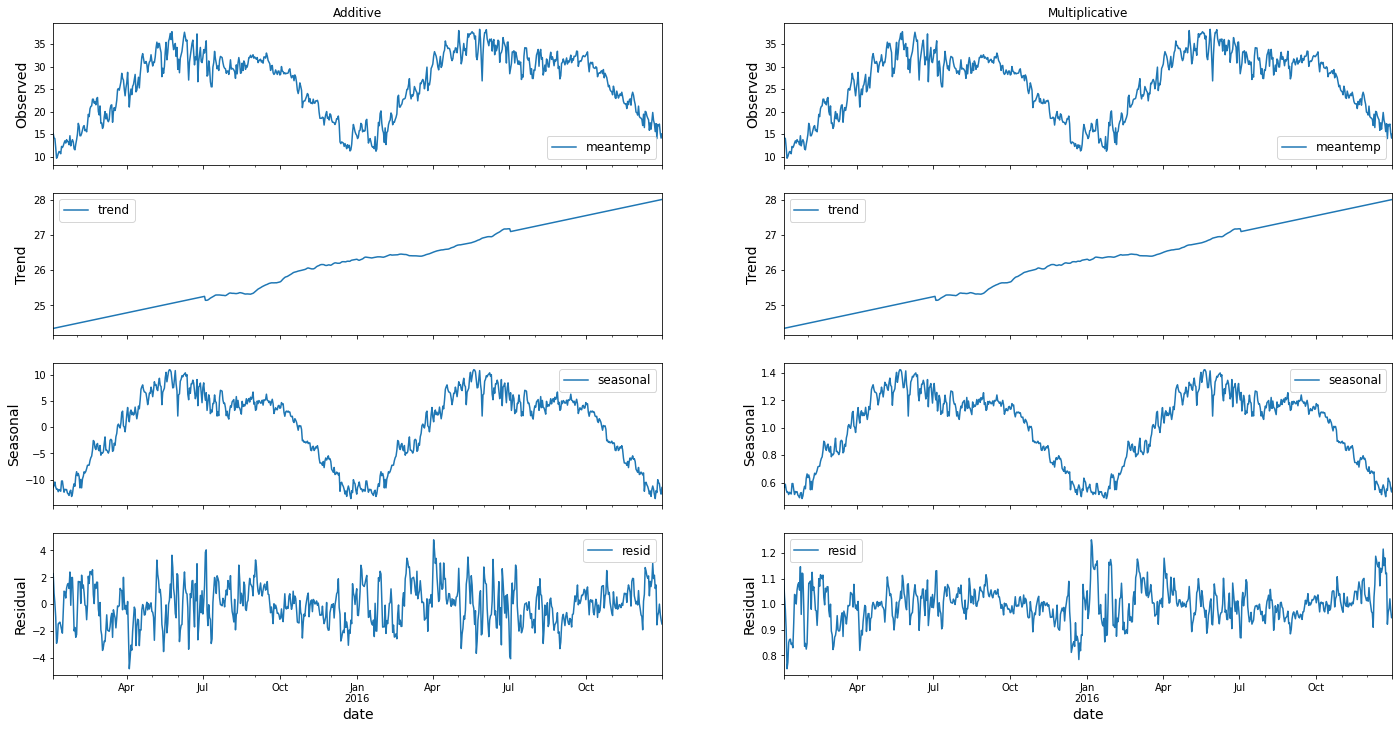

In [271]:
# 1. Additive decomposition
decompose_data_add = seasonal_decompose(dataset['meantemp'], model='additive', extrapolate_trend='freq', period=364)


# 2. Multiplicative decomposition
decompose_data_mul = seasonal_decompose(dataset['meantemp'], model='multiplicative', extrapolate_trend='freq', period=364)


def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=True)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=True)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=True)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=True)
    axes[3].set_ylabel('Residual')


fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(24,12))
plotseasonal(decompose_data_add, axes[:,0])
axes[0,0].set_title('Additive')
plotseasonal(decompose_data_mul, axes[:,1])
axes[0,1].set_title('Multiplicative')
plt.show()

Let's do this manually to check the results:

Detrending the time series

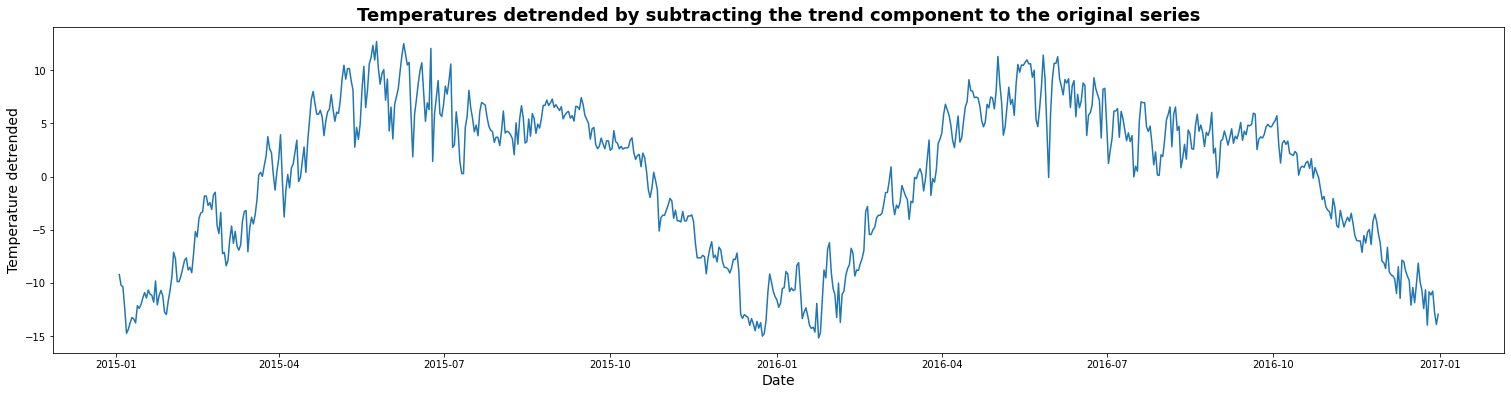

In [272]:
dataset['meantemp_detrended'] = dataset['meantemp'].values - decompose_data_mul.trend
plt.plot(dataset.index, dataset['meantemp_detrended'])
plt.title('Temperatures detrended by subtracting the trend component to the original series', fontsize=18, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature detrended", fontsize=14)
plt.show()

Remove seasonality from the time series.

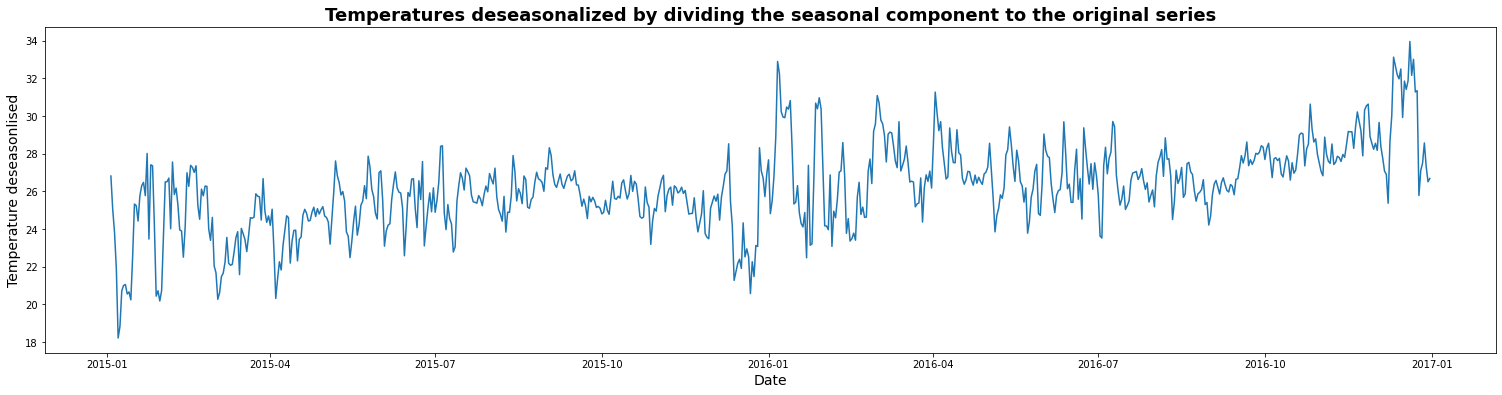

In [273]:
dataset['meantemp_deseasonalized'] = dataset['meantemp'].values / decompose_data_mul.seasonal
plt.plot(dataset.index, dataset['meantemp_deseasonalized'])
plt.title('Temperatures deseasonalized by dividing the seasonal component to the original series', fontsize=18, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature deseasonlised", fontsize=14)
plt.show()

Calculating the residual.

In [274]:
dataset['meantemp_adjusted'] = dataset['meantemp_detrended'].values / dataset['meantemp_deseasonalized']

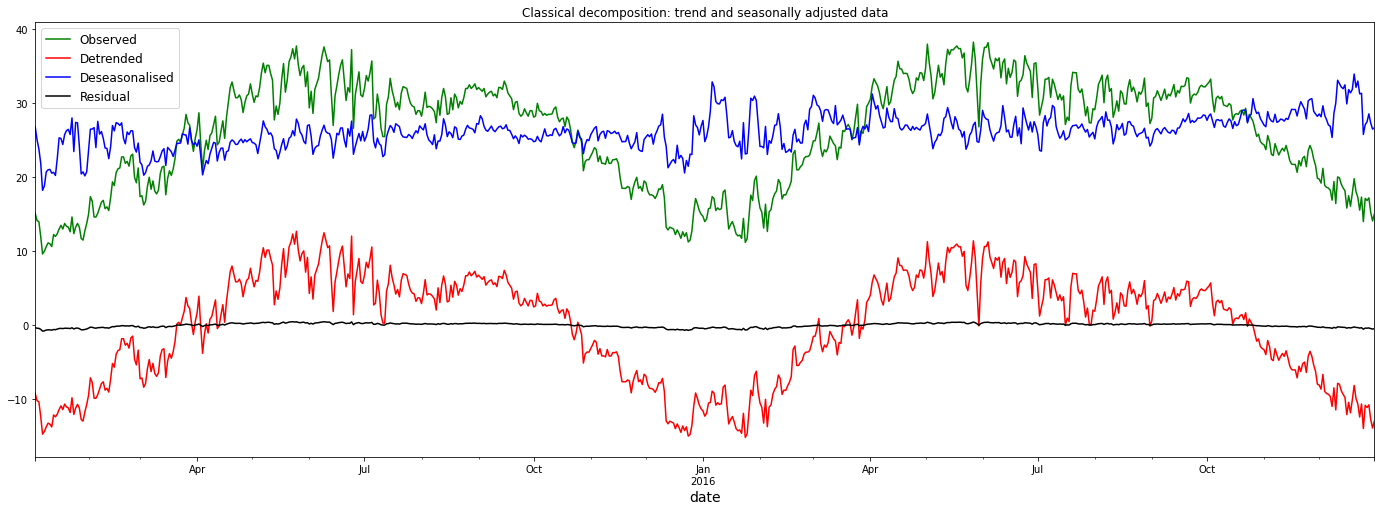

In [275]:
fig, ax = plt.subplots(figsize=(24,8))

dataset['meantemp'].plot(c='g')
dataset['meantemp_detrended'].plot(c='r')
dataset['meantemp_deseasonalized'].plot(c='b')
dataset['meantemp_adjusted'].plot(c='k')
#decompose_data_mul.resid.plot(c='k')

ax.set_title('Classical decomposition: trend and seasonally adjusted data')
ax.legend(['Observed','Detrended','Deseasonalised', 'Residual'])
plt.show()

* STL DECOMPOSITION

In [280]:
stl = STL(dataset['meantemp'], seasonal=365, robust = True)
resSTL = stl.fit()

# Extract the trend and seasonal components 
stl_trend = resSTL.trend
stl_seasonal = resSTL.seasonal

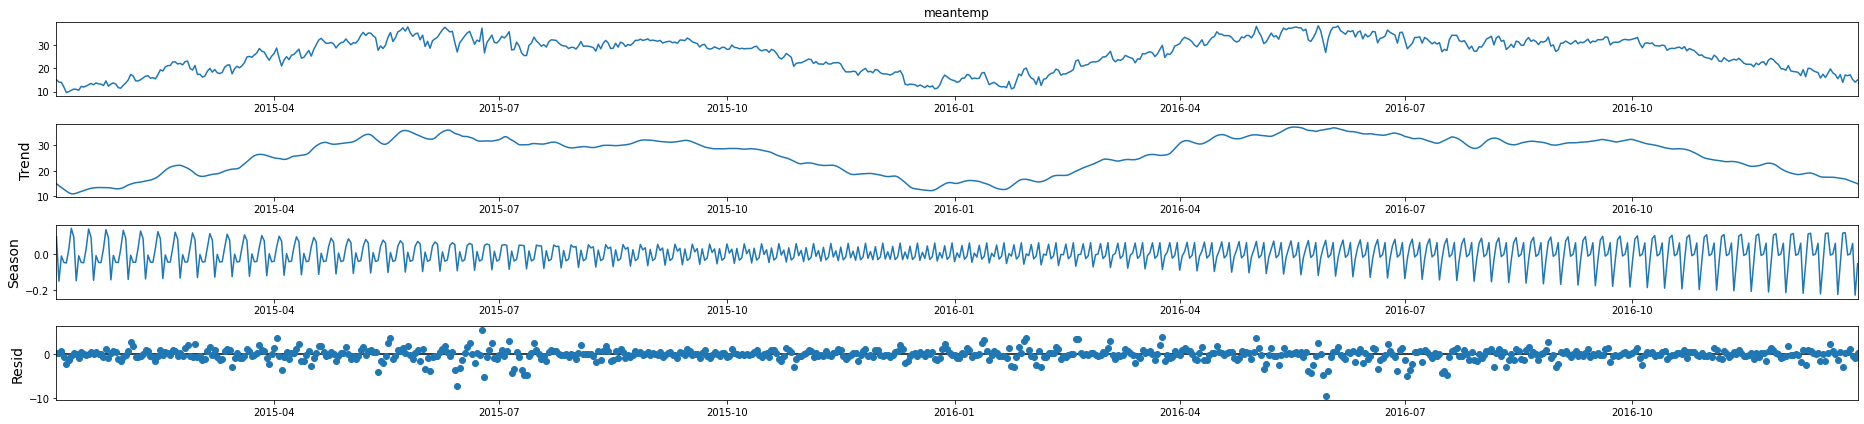

In [291]:
fig = resSTL.plot()

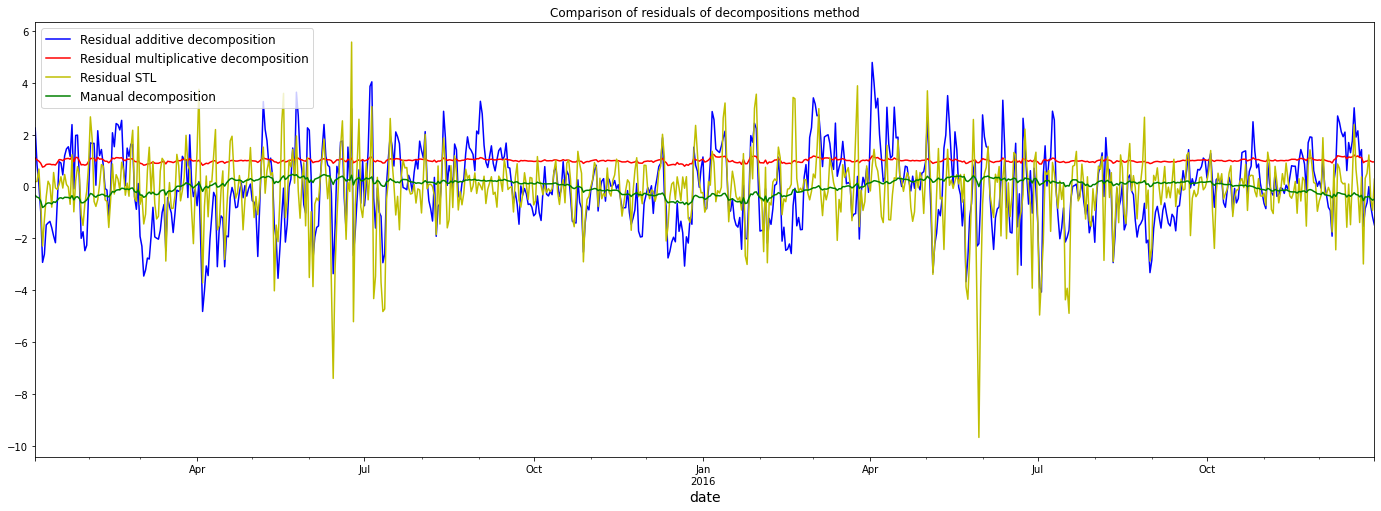

In [293]:
fig, ax = plt.subplots(figsize=(24,8))

decompose_data_add.resid.plot(c='b')
decompose_data_mul.resid.plot(c='r')
resSTL.resid.plot(c='y')
dataset['meantemp_adjusted'].plot(c='g')

ax.set_title('Comparison of residuals of decompositions method')
ax.legend(['Residual additive decomposition', 'Residual multiplicative decomposition', 'Residual STL', 'Manual decomposition'])
plt.show()

Comparing residuals, it's clear that the decomposition method that works best is the classical multiplicative one.

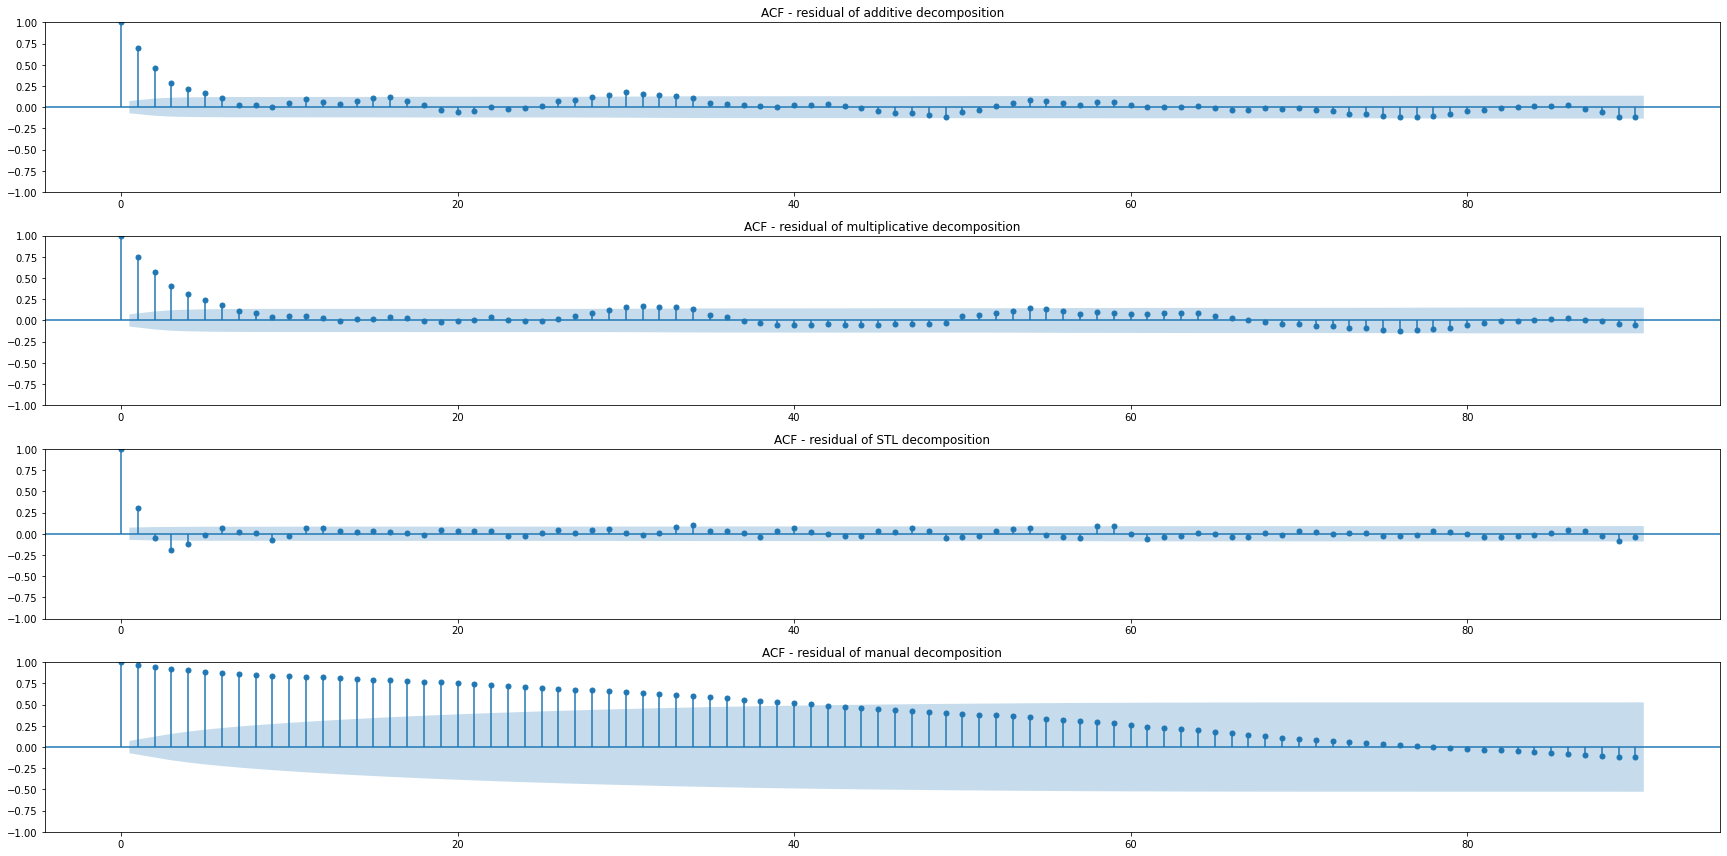

In [323]:
fig = plt.figure(figsize=(24,12)) 
ax1 = plt.subplot2grid(shape=(4, 1), loc=(0, 0), colspan=1)
ax2 = plt.subplot2grid(shape=(4, 1), loc=(1, 0), colspan=1)
ax3 = plt.subplot2grid(shape=(4, 1), loc=(2, 0), colspan=1)
ax4 = plt.subplot2grid(shape=(4, 1), loc=(3, 0), colspan=1)


plot_acf(decompose_data_add.resid, title='ACF - residual of additive decomposition', lags=90, ax=ax1)
plot_acf(decompose_data_mul.resid, title='ACF - residual of multiplicative decomposition', lags=90, ax=ax2)
plot_acf(resSTL.resid, title='ACF - residual of STL decomposition', lags=90, ax=ax3)
plot_acf(dataset['meantemp_adjusted'], title='ACF - residual of manual decomposition', lags=90, ax=ax4)

plt.tight_layout()
plt.show()

In [325]:
print("--- ADDITIVE\n", decompose_data_add.resid.head(3), 
      "\n --- MULTIPLICATIVE \n", decompose_data_mul.resid.head(3),
      "\n --- STL \n",resSTL.resid.head(3), 
      "\n --- MANUAL\n", dataset['meantemp_adjusted'].head(3) 
    )

--- ADDITIVE
 date
2015-01-03    2.255713
2015-01-04    0.826121
2015-01-05    0.071313
Freq: D, Name: resid, dtype: float64 
 --- MULTIPLICATIVE 
 date
2015-01-03    1.101521
2015-01-04    1.028818
2015-01-05    0.978551
Freq: D, Name: resid, dtype: float64 
 --- STL 
 date
2015-01-03    0.184534
2015-01-04    0.201136
2015-01-05    0.673389
Freq: D, Name: resid, dtype: float64 
 --- MANUAL
 date
2015-01-03   -0.343747
2015-01-04   -0.408085
2015-01-05   -0.434416
Freq: D, Name: meantemp_adjusted, dtype: float64


* SMOOTHING THE TIME SERIES

I will apply smoothening on the mean temperatures to: <br>
1. Reducing the effect of noise in a signal get a fair approximation of the noise-filtered series.
1. The smoothed version of series can be used as a feature to explain the original series itself.
3. Visualize the underlying trend better

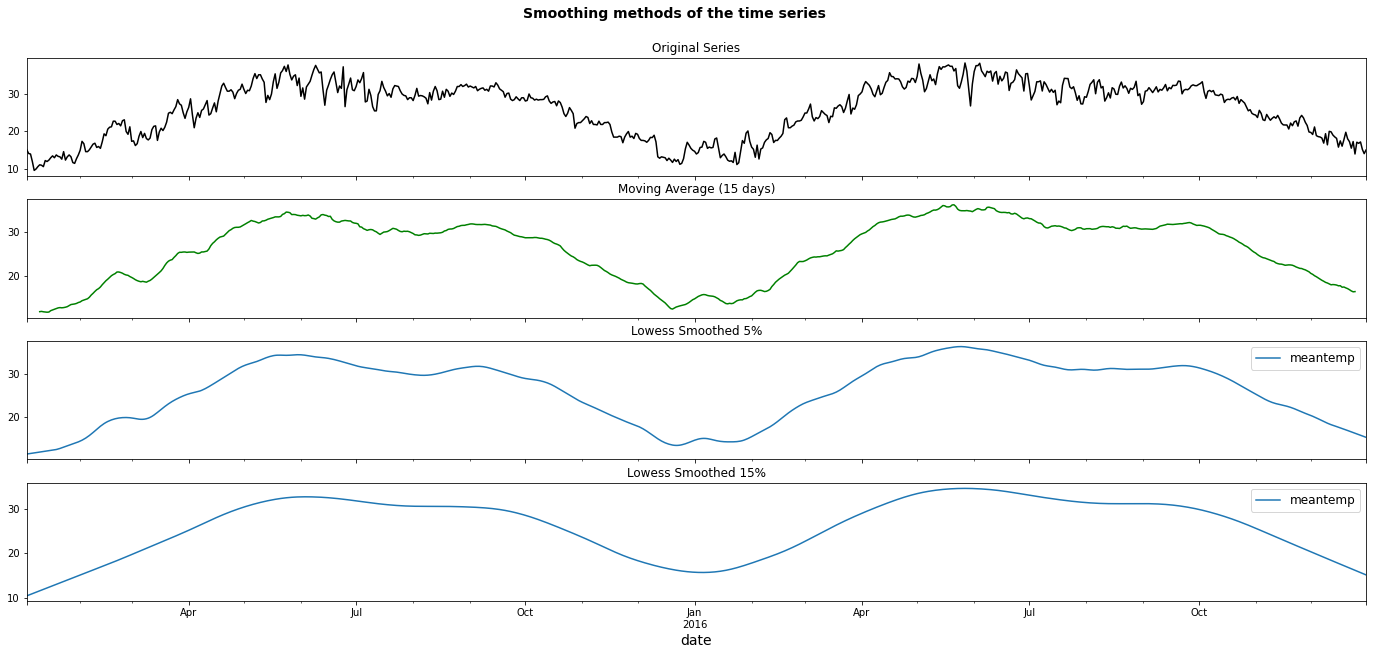

In [328]:
# 1. Moving Average
moving_average = dataset['meantemp'].rolling(15, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
lowess_5 = pd.DataFrame(lowess(dataset['meantemp'], np.arange(len(dataset['meantemp'])), frac=0.05)[:, 1], index=dataset.index, columns=['meantemp'])
lowess_15 = pd.DataFrame(lowess(dataset['meantemp'], np.arange(len(dataset['meantemp'])), frac=0.15)[:, 1], index=dataset.index, columns=['meantemp'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(24, 10), sharex=True)
dataset['meantemp'].plot(ax=axes[0], color='k', title='Original Series')
moving_average.plot(ax=axes[1], title='Moving Average (15 days)', color='g')
lowess_5.plot(ax=axes[2], title='Lowess Smoothed 5%')
lowess_15.plot(ax=axes[3], title='Lowess Smoothed 15%')
fig.suptitle('Smoothing methods of the time series', y=0.95, fontsize=14)
plt.show()

## 5. Forecasting

Now that I have performed all the preliminary analysis, I can go on to the models selection and to the forecasting.

* OLS (Ordinary Least Squares) for linear regression <br>

With OLS I try to predict data by minimising the sum of the squared residuals.

In [329]:
# TRAIN DATA
N = dataset.shape[0]
y_train = np.array(dataset.iloc[:,0]).reshape(N,1)
X_train = np.array(dataset.iloc[:,1:3]).reshape(N,2)

print('X dimension',y_train.shape)
print('y dimension',X_train.shape)


# TEST DATA
N2 = dataset_test.shape[0]
y_test = np.array(dataset_test.iloc[:,0]).reshape(N2,1)
X_test = np.array(dataset_test.iloc[:,1:3]).reshape(N2,2)

print('X dimension',y_test.shape)
print('y dimension',X_test.shape)

X dimension (729, 1)
y dimension (729, 2)
X dimension (90, 1)
y dimension (90, 2)


In [330]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
results = sm.OLS(y_train, X_train).fit()
pred = results.fittedvalues
print(results.summary())

predictions = results.get_prediction(X_test)
df_predictions = predictions.summary_frame()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     178.2
Date:                Sat, 18 Feb 2023   Prob (F-statistic):           1.12e-63
Time:                        12:49:39   Log-Likelihood:                -2318.8
No. Observations:                 729   AIC:                             4644.
Df Residuals:                     726   BIC:                             4657.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.7871      1.114     34.827      0.0

From the summary we get that:
1. R-squared is the measurement of how much of the independent variable is explained by changes in our dependent variables. My model explains 32.9% of the change in the meantemp variable. 
2. F-statisticis is comparing the produced linear model for the variables against a model that replaces the variables’ effect to 0, to find out if the group of variables are statistically significant.
3. Log-likelihood is a numerical signifier of the likelihood that the produced model produced the given data.

4. const is the intercept, i.e. the result of the model if all variables were tuned to 0. In the classic ‘y = mx+b’ linear formula, it is the b.
5. std err is an estimate of the standard deviation of the coefficient, a measurement of the amount of variation in the coefficient throughout its data points.
6. t is related and is a measurement of the precision with which the coefficient was measured. A low std error compared to a high coefficient produces a high t statistic, which signifies a high significance for your coefficient.
7. P>|t| uses the t statistic to produce the p value, a measurement of how likely the coefficient is measured through the model.
8. Omnibus describes the normalcy of the distribution of our residuals using skew and kurtosis as measurements.
9. Prob(Omnibus) is a statistical test measuring the probability the residuals are normally distributed. A 1 would indicate perfectly normal distribution.
10. Skew is a measurement of symmetry in the data, with 0 being perfect symmetry. 
11. Kurtosis measures the peakiness of the data, or its concentration around 0 in a normal curve. Higher kurtosis implies fewer outliers.
12. Durbin-Watson is a measurement of homoscedasticity, or an even distribution of errors throughout our data. Heteroscedasticity would imply an uneven distribution, for example as the data point grows higher the relative error grows higher. Ideal homoscedasticity will lie between 1 and 2.
13. Jarque-Bera (JB) and Prob(JB) are alternate methods of measuring the normalcy using skewness and kurtosis.

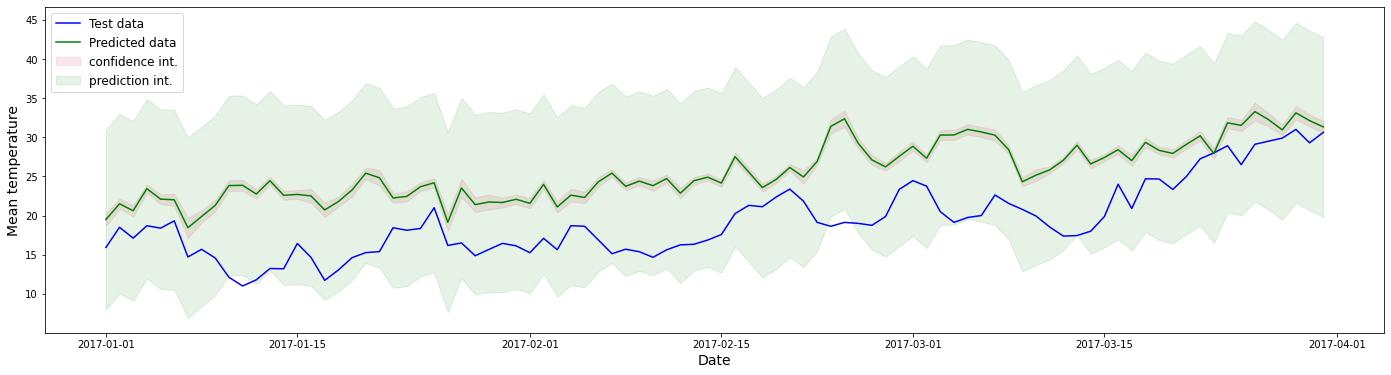

In [333]:
fig = plt.figure(figsize=(24, 6)) 
#plt.plot(dataset['2016'].index, dataset['2016']['meantemp'],'k-', label='Train data') # Uncomment to plot the train data
plt.plot(dataset_test.index, y_test,'b-', label='Test data')
plt.plot(dataset_test.index, df_predictions['mean'],'g-', label='Predicted data')
plt.fill_between(dataset_test.index, df_predictions.mean_ci_lower, df_predictions.mean_ci_upper, alpha=.1, color='crimson', label = 'confidence int.')
plt.fill_between(dataset_test.index, df_predictions.obs_ci_lower, df_predictions.obs_ci_upper, alpha=.1, color='green',label='prediction int.')
plt.xlabel('Date')
plt.ylabel('Mean temperature')
plt.legend()
plt.show()

In [ ]:
print('MAE - Mean Absolute Error =', mean_absolute_error(y_test,  df_predictions['mean']))
print('MSE - Mean Squared Error =',  mean_squared_error(y_test, df_predictions['mean'], squared=True))
print('RMSE - Root Mean Squared Error =',  mean_squared_error(y_test, df_predictions['mean'],  squared=False))
print('MAPE - Mean Absolute Percentage Error =', mean_absolute_percentage_error(y_test, df_predictions['mean'])) 
print('R2 value is: ', r2_score(y_test, df_predictions['mean']))

MAE - Mean Absolute Error = 6.299114068800873
MSE - Mean Squared Error = 49.05867079145576
RMSE - Root Mean Squared Error = 7.004189517100159
MAPE - Mean Absolute Percentage Error = 0.3685083999133884
R2 value is:  -1.2573287446414838


### b. ETS MODELS - HOLT'S WINTER

In [334]:
fitted_model_add = ExponentialSmoothing(
                                    dataset['meantemp'], 
                                    trend="add", 
                                    damped_trend=True,
                                    seasonal="add", 
                                    use_boxcox=True,
                                    initialization_method="estimated",
                                    seasonal_periods=364).fit()
prediction_add = fitted_model_add.forecast(90)
simulations = fitted_model_add.simulate(90, repetitions=100, error="add", random_errors="bootstrap")

In [335]:
fitted_model_mult = ExponentialSmoothing(
                                    dataset['meantemp'], 
                                    trend="add", 
                                    damped_trend=True,
                                    seasonal="mul", 
                                    use_boxcox=True,
                                    initialization_method="estimated",
                                    seasonal_periods=364).fit()
prediction_mul = fitted_model_mult.forecast(90)
simulations = fitted_model_mult.simulate(90, repetitions=100, error="mul", random_errors="bootstrap")

In [337]:
fitted_model_mult_mult = ExponentialSmoothing(
                                    dataset['meantemp'], 
                                    trend="mul", 
                                    damped_trend=True,
                                    seasonal="mul", 
                                    use_boxcox=True,
                                    initialization_method="estimated",
                                    seasonal_periods=364).fit()
prediction_mul_mul = fitted_model_mult_mult.forecast(90)
simulations = fitted_model_mult_mult.simulate(90, repetitions=100, error="mul", random_errors="bootstrap")

In [338]:
results = pd.DataFrame(
    index=['alpha', 'beta','phi', 'gamma', 'l0', 'b0', "SSE"]
)

params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Additive Dam"] = [fitted_model_add.params[p] for p in params] + [fitted_model_add.sse]
results["Multiplica Dam"] = [fitted_model_mult.params[p] for p in params] + [fitted_model_mult.sse]
results["MultiplicaMul Dam"] = [fitted_model_mult_mult.params[p] for p in params] + [fitted_model_mult_mult.sse]

results

Additive Dam  Multiplica Dam  MultiplicaMul Dam
alpha      0.829234        0.818538           0.818499
beta       0.001867        0.000264           0.000347
phi        0.816935        0.990003           0.989623
gamma      0.001556        0.030188           0.030202
l0       165.209267      142.509131         142.525166
b0        -9.152951        0.515920           1.009043
SSE      965.238888      991.230692         990.198271

1. Alpha: Smoothing factor for the level.
2. Beta: Smoothing factor for the trend.
3. Phi: Damping coefficient for the trend.
4. Gamma: Smoothing factor for the seasonality.
4. l0: initial level.
5. b0: initial trend.
7. SSE: sum of the squared errors


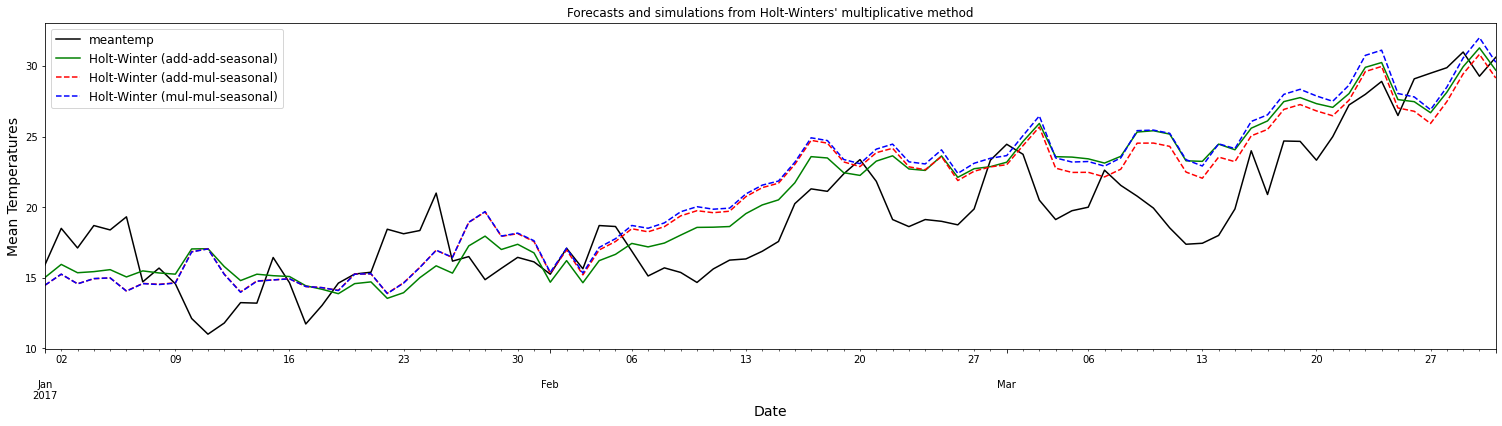

In [391]:
ax = dataset_test['meantemp'].plot(color="black", title="Forecasts and simulations from Holt-Winters' multiplicative method", legend=True)
ax.set_ylabel("Mean Temperatures")
ax.set_xlabel("Date")
#fitted_model_add.fittedvalues.plot(ax=ax, style="-", color="green") # Uncomment to plot train data
#fitted_model_mult.fittedvalues.plot(ax=ax, style="--", color="red") # Uncomment to plot train data
prediction_add.rename("Holt-Winter (add-add-seasonal)").plot(ax=ax, style="-", color="green", legend=True)
prediction_mul.rename("Holt-Winter (add-mul-seasonal)").plot(ax=ax, style="--", color="red", legend=True)
prediction_mul_mul.rename("Holt-Winter (mul-mul-seasonal)").plot(ax=ax, style="--", color="blue", legend=True)
plt.show()

In [340]:
print("Holt-Winters (add-add-seasonal)")
print('MAE - Mean Absolute Error =', mean_absolute_error(dataset_test['meantemp'], prediction_add))
print('MSE - Mean Squared Error =', mean_squared_error(dataset_test['meantemp'], prediction_add,  squared=True))
print('RMSE - Root Mean Squared Error =', mean_squared_error(dataset_test['meantemp'], prediction_add, squared=False))
print('MAPE - Mean Absolute Percentage Error =',  mean_absolute_percentage_error(dataset_test['meantemp'], prediction_add)) 
print('R2 value is: ', r2_score(dataset_test['meantemp'],prediction_add))
print("="*50)
print("Holt-Winters (add-mul-seasonal)")
print('MAE - Mean Absolute Error =', mean_absolute_error(dataset_test['meantemp'], prediction_mul))
print('MSE - Mean Squared Error =', mean_squared_error(dataset_test['meantemp'], prediction_mul,  squared=True))
print('RMSE - Root Mean Squared Error =', mean_squared_error(dataset_test['meantemp'], prediction_mul, squared=False))
print('MAPE - Mean Absolute Percentage Error =',  mean_absolute_percentage_error(dataset_test['meantemp'], prediction_mul)) 
print('R2 value is: ', r2_score(dataset_test['meantemp'],prediction_mul))
print("="*50)
print("Holt-Winters (add-mul-seasonal)")
print('MAE - Mean Absolute Error =', mean_absolute_error(dataset_test['meantemp'], prediction_mul_mul))
print('MSE - Mean Squared Error =', mean_squared_error(dataset_test['meantemp'], prediction_mul_mul,  squared=True))
print('RMSE - Root Mean Squared Error =', mean_squared_error(dataset_test['meantemp'], prediction_mul_mul, squared=False))
print('MAPE - Mean Absolute Percentage Error =',  mean_absolute_percentage_error(dataset_test['meantemp'], prediction_mul_mul)) 
print('R2 value is: ', r2_score(dataset_test['meantemp'],prediction_mul_mul))

Holt-Winters (add-add-seasonal)
MAE - Mean Absolute Error = 2.540258031649762
MSE - Mean Squared Error = 9.224199758945577
RMSE - Root Mean Squared Error = 3.0371367698780998
MAPE - Mean Absolute Percentage Error = 0.14065836351597888
R2 value is:  0.5755683770827044
Holt-Winters (add-mul-seasonal)
MAE - Mean Absolute Error = 2.569878688024071
MSE - Mean Squared Error = 9.29391010603404
RMSE - Root Mean Squared Error = 3.0485914954342506
MAPE - Mean Absolute Percentage Error = 0.14308994985464787
R2 value is:  0.5723608060714422
Holt-Winters (add-mul-seasonal)
MAE - Mean Absolute Error = 2.8091485265959246
MSE - Mean Squared Error = 11.211917905247619
RMSE - Root Mean Squared Error = 3.348420210374979
MAPE - Mean Absolute Percentage Error = 0.15520690955781202
R2 value is:  0.48410782106872974


### c. AUTOREGRESSIVE INTEGRATED MOVING AVERAGE MODELS

### ARIMA

In [341]:
model_ARIMA = auto_arima(
                      dataset['meantemp'], 
                      test='adf',       # use adftest to find optimal 'd'
                      m=1,              # frequency of series NO SEASONALITY in ARIMA
                      d=None,           # With None let model determine 'd'
                      start_p=3,
                      start_q=3,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      stationary=False,
                      seasonal=False    #if m=1 then seasonal set to False
                      )
print(model_ARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2754.628, Time=1.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2804.079, Time=4.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2791.067, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2786.419, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2802.079, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2753.334, Time=0.60 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2751.785, Time=0.29 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2752.659, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2753.937, Time=0.46 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2753.491, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2770.997, Time=0.10 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2751.544, Time=0.19 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2753.437, Time=0.27 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=2752.659, Time=0.65 sec
 ARIMA(0,1,4)(0,0,0)[0]          

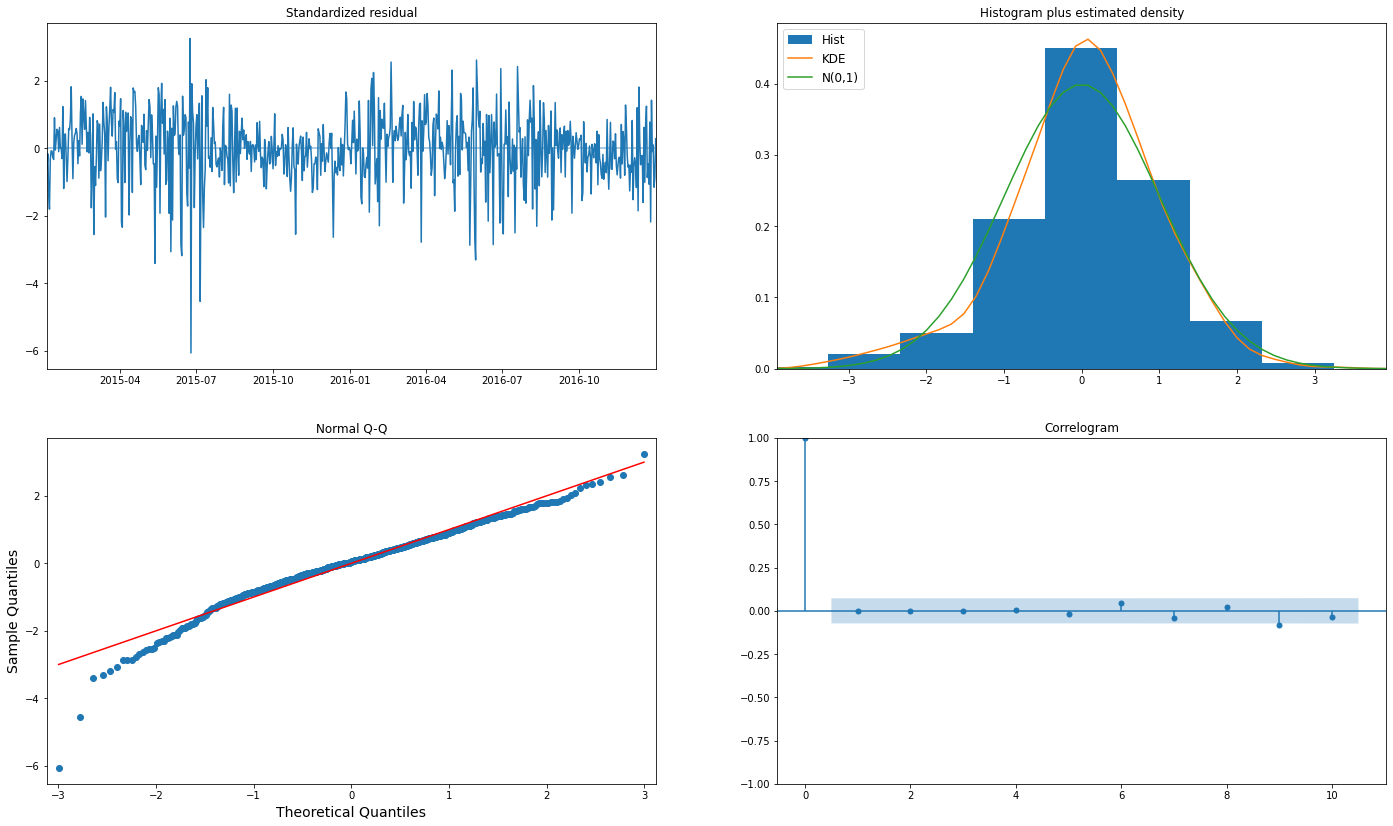

In [342]:
model_ARIMA.plot_diagnostics(figsize=(24,14))
plt.show()

### Interpretation of plots in plot diagnostics
Standardized residual: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.<br>
Histogram: The density plot suggest normal distribution.<br>
Theoretical Quantiles: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.<br>
Correlogram: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model.

Overall, the model seems to be a good fit.

In [343]:
print('Optimal p,d,q parameters suggested are:', model_ARIMA.order) #Print the ARIMA p,d,q parameters

Optimal p,d,q parameters suggested are: (0, 1, 4)


In [344]:
pred_ARIMA = model_ARIMA.predict(n_periods=90)

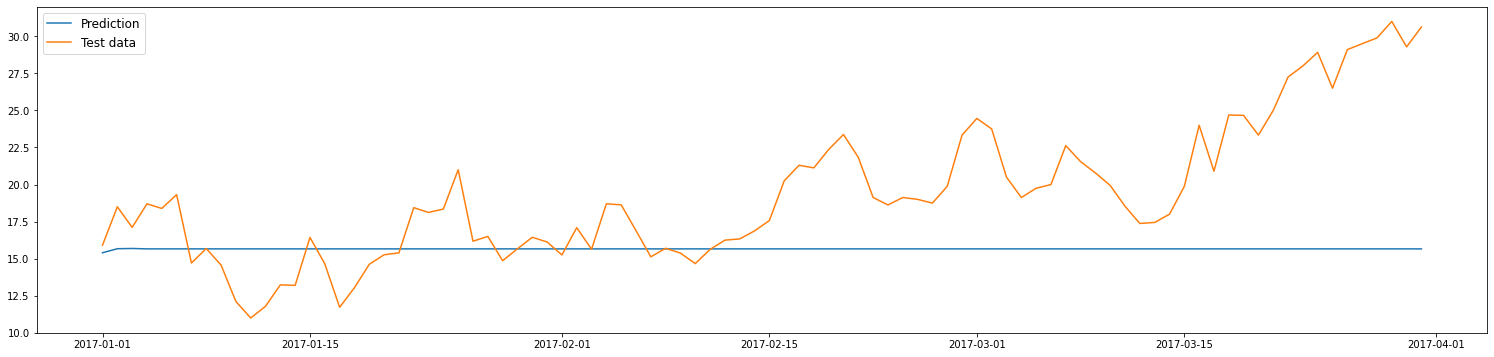

In [345]:
plt.plot(dataset_test.index,pred_ARIMA,label='Prediction')
plt.plot(dataset_test['meantemp'], label='Test data')
plt.legend()
plt.show()

In [346]:
print('MAE - Mean Absolute Error =', mean_absolute_error(dataset_test['meantemp'], pred_ARIMA))
print('MSE - Mean Squared Error =', mean_squared_error(dataset_test['meantemp'], pred_ARIMA,  squared=True))
print('RMSE - Root Mean Squared Error =', mean_squared_error(dataset_test['meantemp'], pred_ARIMA, squared=False))
print('MAPE - Mean Absolute Percentage Error =',  mean_absolute_percentage_error(dataset_test['meantemp'], pred_ARIMA)) 
print('R2 value is: ', r2_score(dataset_test['meantemp'],pred_ARIMA))
print("AIC values {}".format(model_ARIMA.aic()))

MAE - Mean Absolute Error = 4.341336246077065
MSE - Mean Squared Error = 34.99756821982811
RMSE - Root Mean Squared Error = 5.915874256593704
MAPE - Mean Absolute Percentage Error = 0.19835760573968136
R2 value is:  -0.61033748898326
AIC values 2749.5573490368697


### MANUAL ARIMA

In [363]:
model_ARIMA_manual = ARIMA(dataset['meantemp'], order=(2,1,3)).fit() 
print(model_ARIMA_manual.summary())

#With:
#4,0,1 we get best MAE 3.52
#8,0,0 MAE 3.30

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                  729
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1369.674
Date:                Sat, 18 Feb 2023   AIC                           2751.348
Time:                        13:44:07   BIC                           2778.890
Sample:                    01-03-2015   HQIC                          2761.975
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5524      0.378      1.460      0.144      -0.189       1.294
ar.L2         -0.1798      0.238     -0.756      0.450      -0.646       0.286
ma.L1         -0.7633      0.381     -2.004      0.0

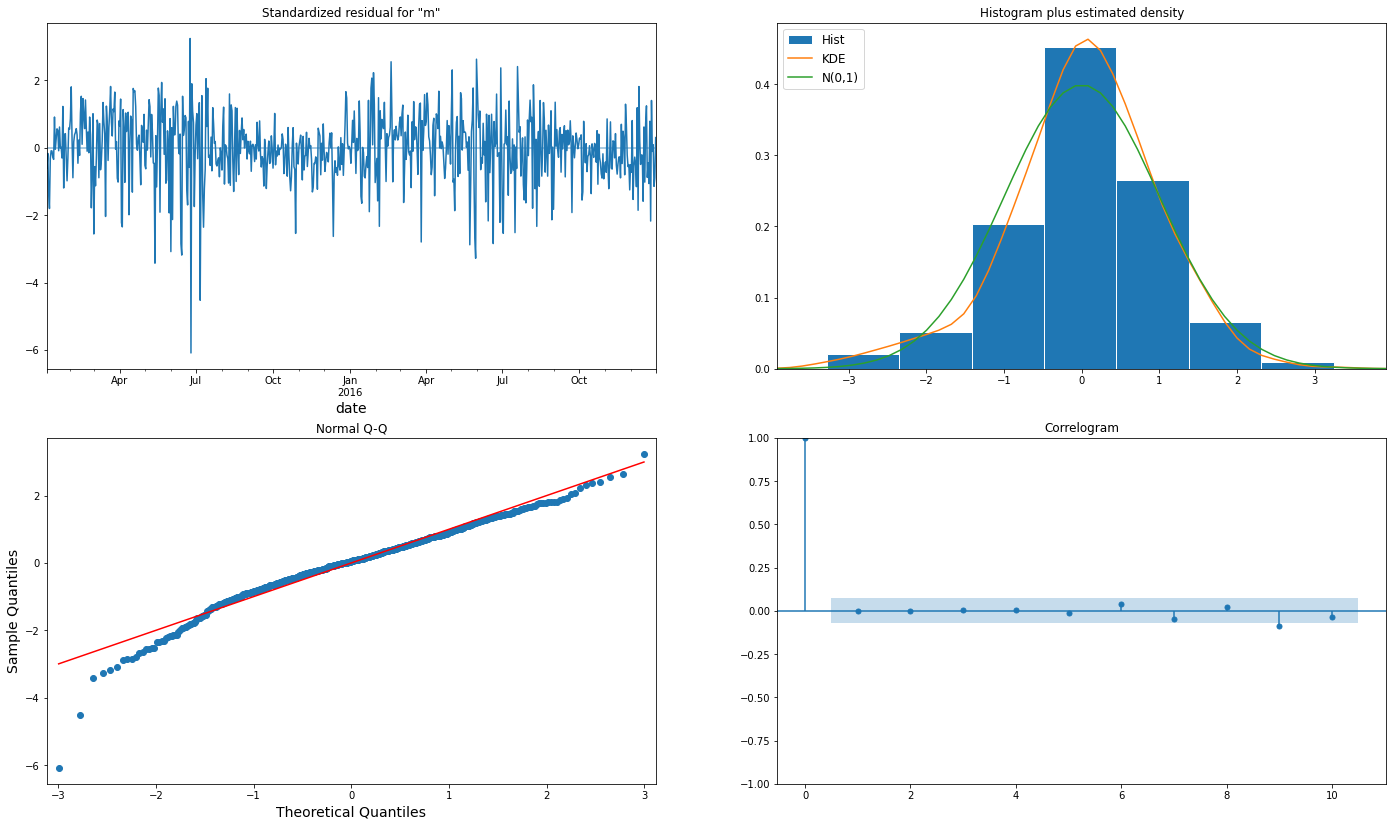

In [364]:
model_ARIMA_manual.plot_diagnostics(figsize=(24,14))
plt.show()

### Interpretation of plots in plot diagnostics
Standardized residual: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.<br>
Histogram: The density plot suggest normal distribution.<br>
Theoretical Quantiles: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.<br>
Correlogram: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model.

Overall, the model seems to be a good fit.

In [366]:
# Jarque-Bera Test --> Check if the sample data has the skewness and kurtosis matching a normal distribution.
jb_statistic = stats.jarque_bera(model_ARIMA_manual.resid)
print('JB p-value for residuals:', jb_statistic.pvalue, " and test statistic: ", jb_statistic.statistic)

JB p-value for residuals: 0.0  and test statistic:  3344.4112965634336


the test statistic is high, while the p-value is very small, therefore the null hypothesis assuming the data is from a normal distribution is rejected.

In [365]:
# Ljung-Box Q-Test --> Check for the presence of autocorrelation 
LB_AR2 = acorr_ljungbox(model_ARIMA_manual.resid, lags=[365], return_df=True)
print('LB p-value for residuals', float(LB_AR2['lb_pvalue']))

LB p-value for residuals 0.6116396398723394


p-value > 0.05 we cannot reject the H0 and so, the residuals are not correlated.

In [367]:
# Durbin-Watson Test --> Check for the presence of autocorrelation
res = model_ARIMA_manual.resid
dw_res_man = durbin_watson(res)
print('DW statistic:', dw_res_man)

DW statistic: 1.9020759871313508


the statistic is close to 2, so there is no serial autocorrelation.

In [368]:
pred_ARIMA_manual = model_ARIMA_manual.get_prediction(start=dataset_test.index[0], end=dataset_test.index[-1]) 
df_ARIMA_manual  = pred_ARIMA_manual.summary_frame()

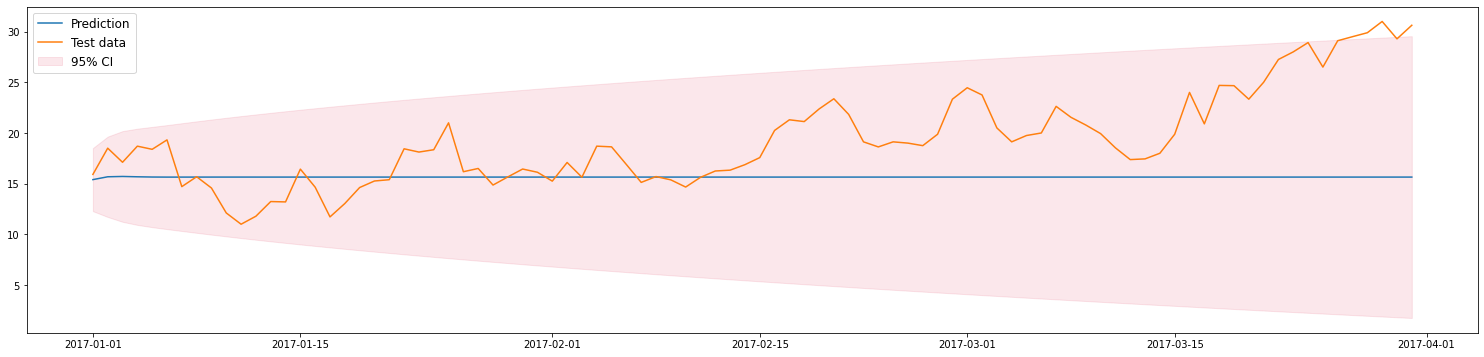

In [369]:
plt.plot(dataset_test.index,df_ARIMA_manual['mean'],label='Prediction')
plt.plot(dataset_test['meantemp'], label='Test data')
plt.fill_between(dataset_test.index, df_ARIMA_manual['mean_ci_lower'], df_ARIMA_manual['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.legend()
plt.show()

In [370]:
print('MAE - Mean Absolute Error =', mean_absolute_error(dataset_test['meantemp'], df_ARIMA_manual['mean']))
print('MSE - Mean Squared Error =', mean_squared_error(dataset_test['meantemp'], df_ARIMA_manual['mean'],  squared=True))
print('RMSE - Root Mean Squared Error =', mean_squared_error(dataset_test['meantemp'], df_ARIMA_manual['mean'], squared=False))
print('MAPE - Mean Absolute Percentage Error =',  mean_absolute_percentage_error(dataset_test['meantemp'], df_ARIMA_manual['mean'])) 
print('R2 value is: ', r2_score(dataset_test['meantemp'],df_ARIMA_manual['mean']))

MAE - Mean Absolute Error = 4.34614700572533
MSE - Mean Squared Error = 35.07012476650565
RMSE - Root Mean Squared Error = 5.922003441953208
MAPE - Mean Absolute Percentage Error = 0.19853896731432777
R2 value is:  -0.6136760217193662


### SARIMAX

In [371]:
exogenous_var = dataset[['wind_speed','humidity']]
exogenous_var_test = dataset_test[['wind_speed','humidity']]

In [372]:
model_SARIMAX = auto_arima( 
                    dataset['meantemp'],  
                    X=exogenous_var, #exogenous variables
                    d=None, 
                    D=None,
                    m=7, 
                    alpha=0.05,
                    start_p=3,
                    start_q=3,
                    stationary=False,
                    seasonal=True,
                    test='adf',
                    trace=True, 
                    information_criterion='aic',
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

#With 4,1,1, 0,0,0,7 best MAE is 2.73
print(model_SARIMAX.summary())

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(1,0,1)[7] intercept   : AIC=2342.198, Time=3.09 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2385.817, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2389.610, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2389.583, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2383.817, Time=0.17 sec
 ARIMA(3,1,3)(0,0,1)[7] intercept   : AIC=2340.213, Time=2.42 sec
 ARIMA(3,1,3)(0,0,0)[7] intercept   : AIC=2338.442, Time=2.28 sec
 ARIMA(3,1,3)(1,0,0)[7] intercept   : AIC=2340.206, Time=2.68 sec
 ARIMA(2,1,3)(0,0,0)[7] intercept   : AIC=2340.580, Time=0.86 sec
 ARIMA(3,1,2)(0,0,0)[7] intercept   : AIC=2342.400, Time=0.85 sec
 ARIMA(4,1,3)(0,0,0)[7] intercept   : AIC=2340.939, Time=1.90 sec
 ARIMA(3,1,4)(0,0,0)[7] intercept   : AIC=2340.202, Time=1.93 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=2342.563, Time=0.86 sec
 ARIMA(2,1,4)(0,0,0)[7] intercept   : AIC=2340.163, Time=0.92 sec
 ARIMA(4,1,2)(0,0,0)[7] intercept

In [373]:
print(model_SARIMAX.order) #Print SARIMAX p,d,q
print(model_SARIMAX.seasonal_order) #Print SARIMAX P,D,Q,F

(3, 1, 3)
(0, 0, 0, 7)


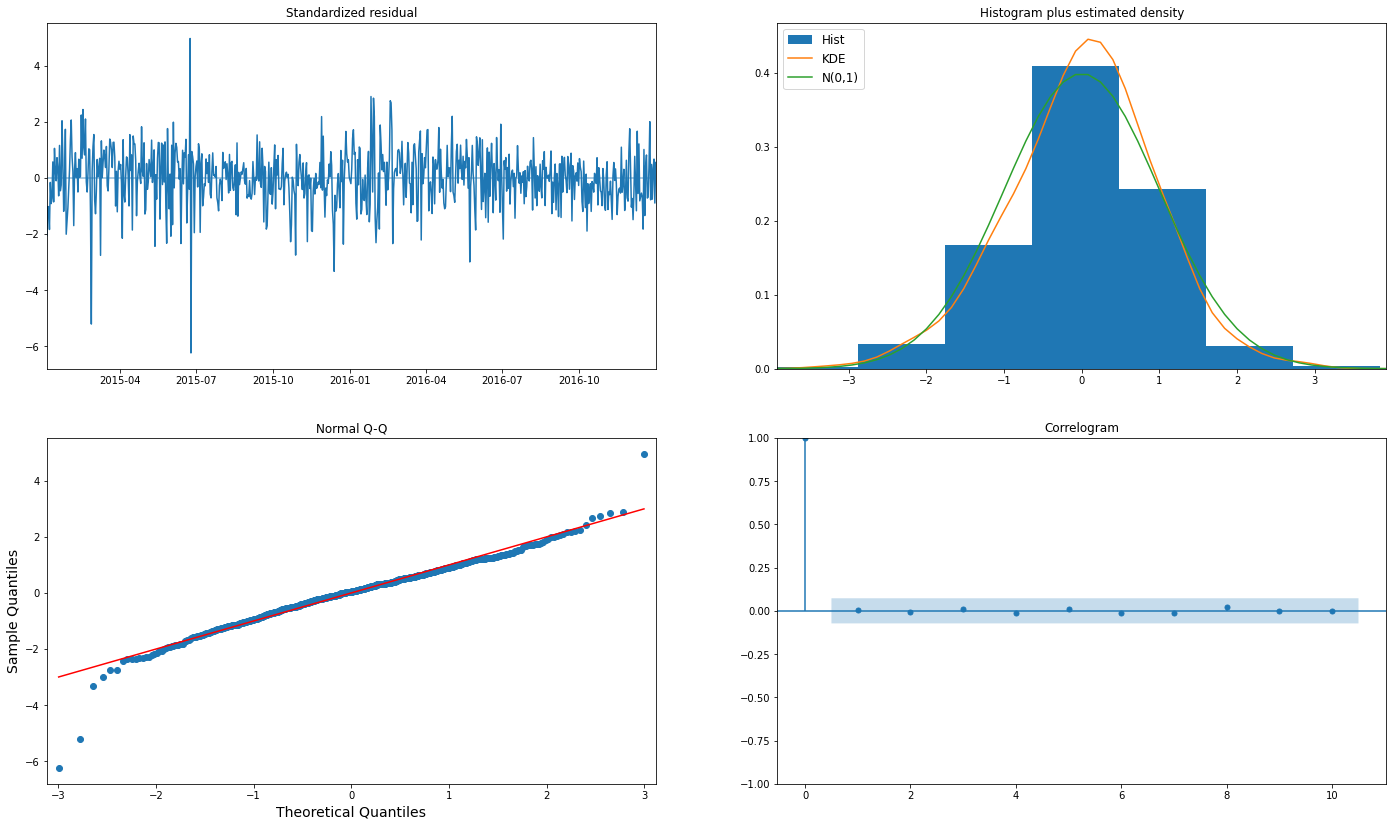

In [374]:
model_SARIMAX.plot_diagnostics(figsize=(24,14))
plt.show()

### Interpretation of plots in plot diagnostics
Standardized residual: The residual errors seem to fluctuate around a mean of zero and have a uniform variance. <br>
Histogram: The density plot suggest normal distribution. With a small shift of the mean to the right.<br>
Theoretical Quantiles: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.<br>
Correlogram: (ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model.

Overall, the model seems to be a good fit.

In [375]:
pred_SARIMAX = model_SARIMAX.predict(n_periods=90, X=exogenous_var_test, alpha=0.05)

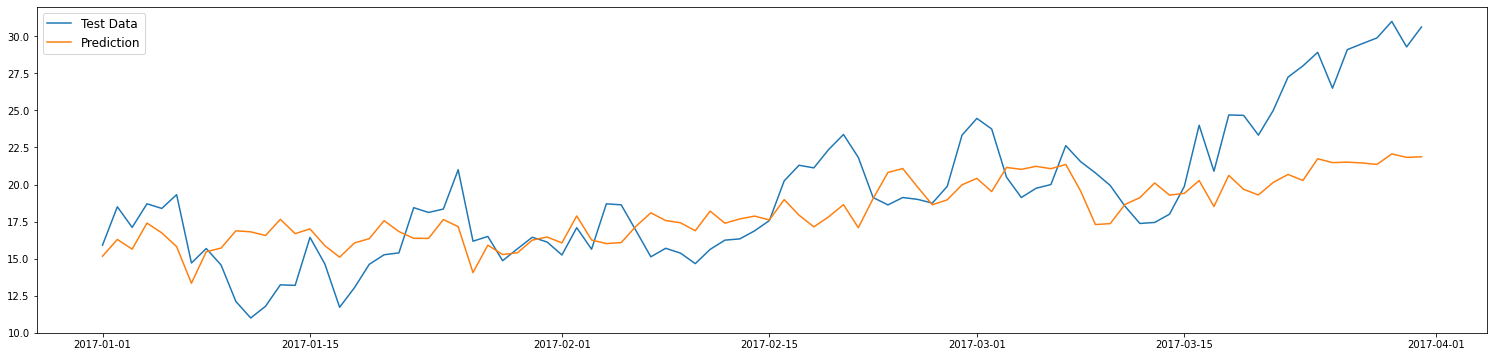

In [376]:
plt.plot(dataset_test.index,dataset_test['meantemp'], label='Test Data')
plt.plot(dataset_test.index,pred_SARIMAX,label='Prediction')
plt.legend()
plt.show()

In [377]:
print('MAE - Mean Absolute Error =', mean_absolute_error(dataset_test['meantemp'], pred_SARIMAX))
print('MSE - Mean Squared Error =', mean_squared_error(dataset_test['meantemp'], pred_SARIMAX,  squared=True))
print('RMSE - Root Mean Squared Error =', mean_squared_error(dataset_test['meantemp'], pred_SARIMAX, squared=False))
print('MAPE - Mean Absolute Percentage Error =',  mean_absolute_percentage_error(dataset_test['meantemp'], pred_SARIMAX)) 
print('R2 value is: ', r2_score(dataset_test['meantemp'],pred_SARIMAX))
print("AIC values {}".format(model_SARIMAX.aic()))

MAE - Mean Absolute Error = 2.7404683215544567
MSE - Mean Squared Error = 12.529122488659773
RMSE - Root Mean Squared Error = 3.5396500517225955
MAPE - Mean Absolute Percentage Error = 0.13662638711402145
R2 value is:  0.42349949799880215
AIC values 2336.451021185054


### MANUAL SARIMAX

In [378]:
model_SARIMAX_manual = SARIMAX(
                                dataset['meantemp'], 
                                exog=exogenous_var,
                                order=(3,1,1), 
                                seasonal_order=(2,0,0,7) 
                                #enforce_stationarity=False,
                                #enforce_invertibility=False
                            ) 
result_SARIMAX_manual = model_SARIMAX_manual.fit()

#With 
# 3,0,0 4,1,0,7 MAE 2.80 
# 3,1,0 4,0,0,7 MAE 2.73 
# 3,1,1 2,0,0,7 MAE 2.72

print(result_SARIMAX_manual.summary()) 

                                     SARIMAX Results                                      
Dep. Variable:                           meantemp   No. Observations:                  729
Model:             SARIMAX(3, 1, 1)x(2, 0, [], 7)   Log Likelihood               -1161.549
Date:                            Sat, 18 Feb 2023   AIC                           2341.099
Time:                                    13:47:30   BIC                           2382.411
Sample:                                01-03-2015   HQIC                          2357.039
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wind_speed    -0.0401      0.010     -3.874      0.000      -0.060      -0.020
humidity      -0.1429      0.005   

### Interpretation of plots in plot diagnostics
Standardized residual: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.<br>
Histogram: The density plot suggest normal distribution.<br>
Theoretical Quantiles: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.<br>
Correlogram: (ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model.

Overall, the model seems to be a good fit.

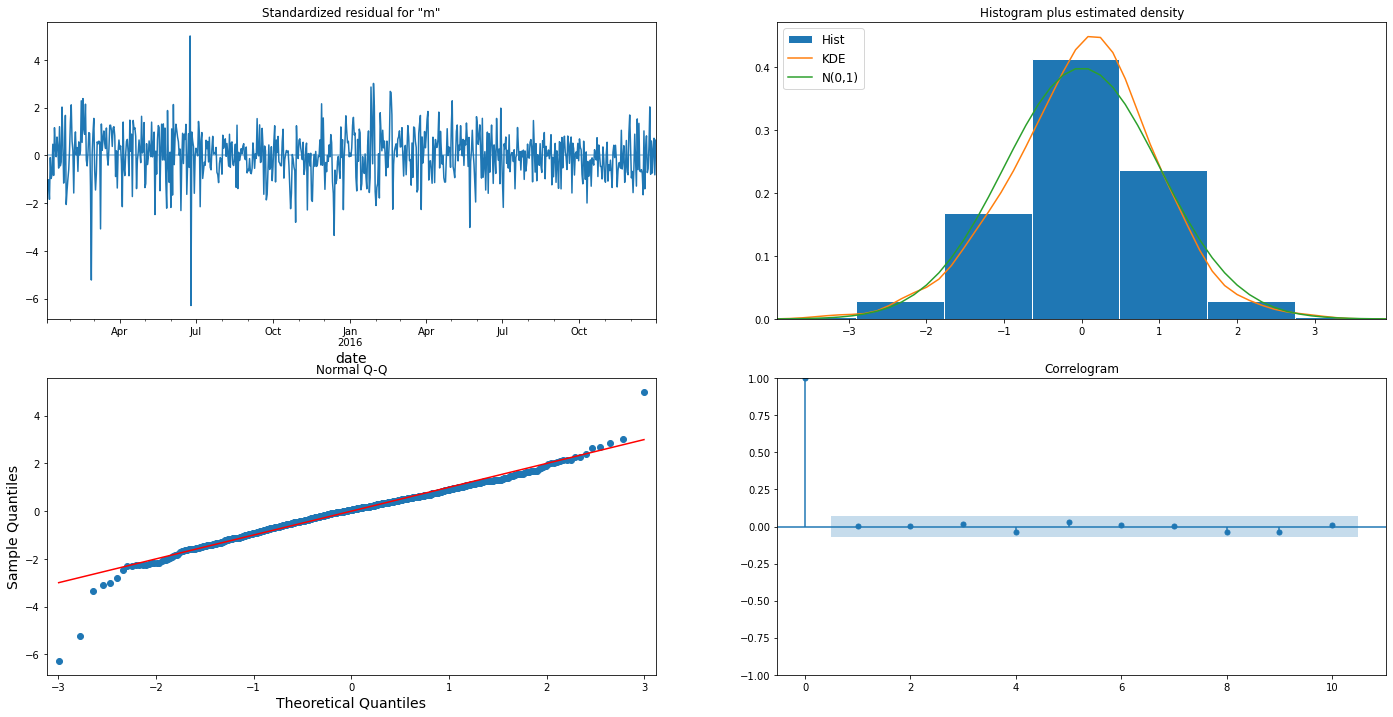

In [379]:
result_SARIMAX_manual.plot_diagnostics(figsize=(24,12))
plt.show()

In [380]:
# Ljung-Box Q-Test --> Check for the presence of autocorrelation 
LB_AR2 = acorr_ljungbox(result_SARIMAX_manual.resid, lags=[365], return_df=True) # [] to consider a single lag, otherwise it will return the values for all the lags up to that number
print('LB p-value for residuals', float(LB_AR2['lb_pvalue']))

LB p-value for residuals 0.9999999991831322


p-value > 0.05 we cannot reject the H0 and so, the residuals are not correlated.

In [381]:
# Jarque-Bera Test --> Check if the sample data has the skewness and kurtosis matching a normal distribution.
jb_statistic = stats.jarque_bera(result_SARIMAX_manual.resid)
print('JB p-value for residuals:', jb_statistic.pvalue, " and test statistic: ", jb_statistic.statistic)

JB p-value for residuals: 0.0  and test statistic:  577906.8347140764


the test statistic is high, while the p-value is very small, therefore the null hypothesis assuming the data is from a normal distribution is rejected.

In [382]:
# Durbin-Watson Test --> Check for the presence of autocorrelation
dw_res_man = durbin_watson(result_SARIMAX_manual.resid)
print('dw statistic:', dw_res_man)

dw statistic: 1.6413440776999224


the statistic is close to 2, so there is no serial autocorrelation.

In [383]:
pred_SARIMAX_manual = result_SARIMAX_manual.get_prediction(start=dataset_test.index[0], end=dataset_test.index[-1], exog=exogenous_var_test) 
df_SARIMAX_manual  = pred_SARIMAX_manual.summary_frame()

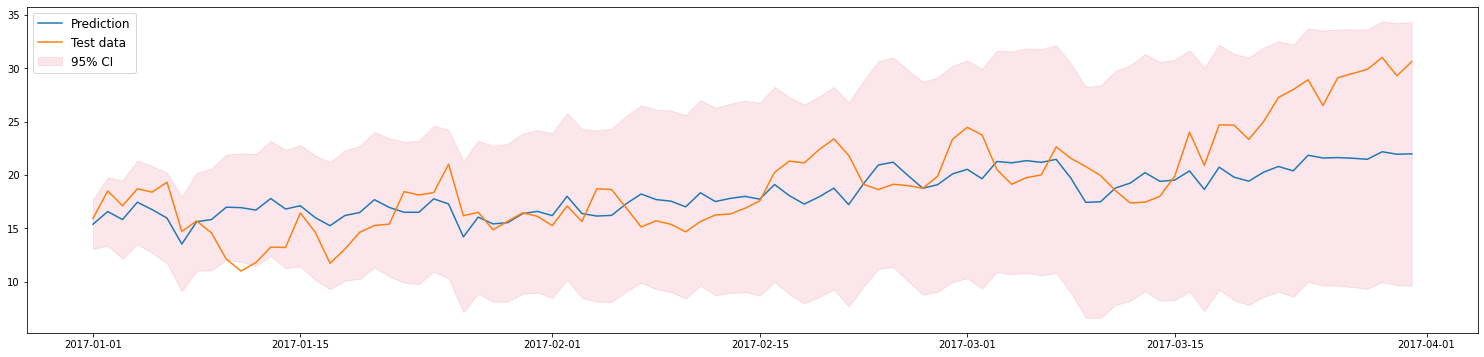

In [384]:
plt.plot(dataset_test.index,df_SARIMAX_manual['mean'],label='Prediction')
plt.plot(dataset_test['meantemp'], label='Test data')
plt.fill_between(dataset_test.index, df_SARIMAX_manual['mean_ci_lower'],df_SARIMAX_manual['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.legend()
plt.show()

In [385]:
print('MAE - Mean Absolute Error =', mean_absolute_error(dataset_test['meantemp'], df_SARIMAX_manual['mean']))
print('MSE - Mean Squared Error =', mean_squared_error(dataset_test['meantemp'], df_SARIMAX_manual['mean'],  squared=True))
print('RMSE - Root Mean Squared Error =', mean_squared_error(dataset_test['meantemp'], df_SARIMAX_manual['mean'], squared=False))
print('MAPE - Mean Absolute Percentage Error =',  mean_absolute_percentage_error(dataset_test['meantemp'], df_SARIMAX_manual['mean'])) 
print('R2 value is: ', r2_score(dataset_test['meantemp'],df_SARIMAX_manual['mean']))

MAE - Mean Absolute Error = 2.7244884999709735
MSE - Mean Squared Error = 12.292875304011886
RMSE - Root Mean Squared Error = 3.5061196933379053
MAPE - Mean Absolute Percentage Error = 0.13666312240623446
R2 value is:  0.43436990178559165


So to conclude, the best model is (as expected) the <b>SARIMAX</b>, which models trend, seasonality and it takes into account also exogenous variables like the wind speed and the humidity. <br>
Interesting is that the overall best performing model with MAE 2.5 is the <b>Holts Winter</b>, which models seasonality and trend as well as the SARIMAX.